In [ ]:
%pip install scanpy pandas numpy
# Import required libraries for single-cell RNA-seq analysis and data handling
import scanpy as sc  # Main library for single-cell analysis, provides AnnData structure and many tools
import pandas as pd  # For tabular data manipulation and metadata handling
import numpy as np   # For numerical operations and array handling
import os            # For operating system interactions (file paths, etc.)
from pathlib import Path  # For robust and readable file path management

# Print versions to ensure reproducibility and compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

   ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/2.1 MB 9.4 MB/s eta 0:00:01Downloading scanpy-1.11.5-py3-none-any.whl (2.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.7 MB ? eta -:--:--Downloading legacy_api_wrap-1.4.1-py3-none-any.whl (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 90.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 90.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.7 MB ? eta -:--:--Downloading seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.

/tmp/ipykernel_55/3576863463.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


In [ ]:
%%time
# --- Install required packages for genetic sequence encoding and ML ---
%pip install biopython
%pip install scikit-learn
%pip install umap-learn
%pip install hdbscan
%pip install plotly
%pip install xgboost
%pip install tensorflow

from Bio.Seq import Seq
from Bio.SeqUtils import ProtParam
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import scipy for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import umap
import hdbscan
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Additional libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.3 MB ? eta -:--:--Requirement already satisfied: tcmlib==1.* in /usr/local/lib/python3.11/dist-packages (from tbb==2022.*->mkl->numpy->biopython) (1.4.0)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart 

2025-10-24 19:04:09.157276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761332649.482436      55 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761332649.571335      55 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Additional libraries installed!
CPU times: user 34.1 s, sys: 5.35 s, total: 39.4 s
Wall time: 1min 24s


In [ ]:
import pandas as pd
import requests
import os
import tarfile
from io import BytesIO

In [ ]:
import gzip
import shutil
from pathlib import Path
import pandas as pd
from scipy.io import mmread

def decompress_gz_file(gz_path, output_dir):
    """
    Decompress a .gz file to the specified output directory.
    """
    output_path = os.path.join(output_dir, Path(gz_path).stem)
    print(f"Decompressing {gz_path} → {output_path}")
    try:
        with gzip.open(gz_path, 'rb') as f_in, open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        return output_path
    except Exception as e:
        print(f"Failed to decompress {gz_path}: {e}")
        return None

def preview_file(file_path):
    """
    Display the first few lines of a decompressed file, based on its extension.
    """
    print(f"\n--- Preview of {os.path.basename(file_path)} ---")
    try:
        if file_path.endswith(".tsv"):
            df = pd.read_csv(file_path, sep='\t')
            print(df.head())
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
            print(df.head())
        elif file_path.endswith(".mtx"):
          matrix = mmread(file_path).tocoo()
          print("First 5 non-zero entries:")
          for i in range(min(5, len(matrix.data))):
              print(f"Row: {matrix.row[i]}, Col: {matrix.col[i]}, Value: {matrix.data[i]}")
          print(f"\nMatrix shape: {matrix.shape}, NNZ (non-zero elements): {matrix.nnz}")
        else:
            print("Unsupported file type for preview.")
    except Exception as e:
        print(f"Could not preview {file_path}: {e}")

extract_dir = os.path.join(download_dir, "GSE300475_RAW")

for root, _, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".gz"):
            gz_file_path = os.path.join(root, file)
            decompressed_path = decompress_gz_file(gz_file_path, root)
            if decompressed_path:
                preview_file(decompressed_path)

Decompressing ../Data/GSE300475_RAW/GSM9061673_S9_matrix.mtx.gz → ../Data/GSE300475_RAW/GSM9061673_S9_matrix.mtx
First 5 non-zero entries:
Row: 24, Col: 0, Value: 1
Row: 44, Col: 0, Value: 1
Row: 60, Col: 0, Value: 1
Row: 62, Col: 0, Value: 1
Row: 170, Col: 0, Value: 9

Matrix shape: (36604, 9704), NNZ (non-zero elements): 17591287
Decompressing ../Data/GSE300475_RAW/GSM9061675_S11_barcodes.tsv.gz → ../Data/GSE300475_RAW/GSM9061675_S11_barcodes.tsv

--- Preview of GSM9061675_S11_barcodes.tsv ---
   AAACCTGAGATGCCTT-1
0  AAACCTGAGGCTAGGT-1
1  AAACCTGAGTGTACTC-1
2  AAACCTGCAGTATGCT-1
3  AAACCTGCATCCTTGC-1
4  AAACCTGGTATAGTAG-1
Decompressing ../Data/GSE300475_RAW/GSM9061669_S5_features.tsv.gz → ../Data/GSE300475_RAW/GSM9061669_S5_features.tsv

--- Preview of GSM9061669_S5_features.tsv ---
   ENSG00000243485 MIR1302-2HG  Gene Expression
0  ENSG00000237613     FAM138A  Gene Expression
1  ENSG00000186092       OR4F5  Gene Expression
2  ENSG00000238009  AL627309.1  Gene Expression
3  ENSG0000

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Preview of GSM9061672_S8_features.tsv ---
   ENSG00000243485 MIR1302-2HG  Gene Expression
0  ENSG00000237613     FAM138A  Gene Expression
1  ENSG00000186092       OR4F5  Gene Expression
2  ENSG00000238009  AL627309.1  Gene Expression
3  ENSG00000239945  AL627309.3  Gene Expression
4  ENSG00000239906  AL627309.2  Gene Expression
Decompressing ../Data/GSE300475_RAW/GSM9061667_S3_features.tsv.gz → ../Data/GSE300475_RAW/GSM9061667_S3_features.tsv

--- Preview of GSM9061667_S3_features.tsv ---
   ENSG00000243485 MIR1302-2HG  Gene Expression
0  ENSG00000237613     FAM138A  Gene Expression
1  ENSG00000186092       OR4F5  Gene Expression
2  ENSG00000238009  AL627309.1  Gene Expression
3  ENSG00000239945  AL627309.3  Gene Expression
4  ENSG00000239906  AL627309.2  Gene Expression
Decompressing ../Data/GSE300475_RAW/GSM9061665_S1_matrix.mtx.gz → ../Data/GSE300475_RAW/GSM9061665_S1_matrix.mtx

--- Preview of GSM9061665_S1_matrix.mtx ---

--- Preview of GSM9061665_S1_matrix.mtx ---
First 5 no

In [ ]:
%%time
# --- Unsupervised Machine Learning Analysis ---

print("Applying unsupervised machine learning algorithms...")

import gc
import numpy as np
import os
import random

clustering_results_dir = 'Processed_Data/clustering_results'
os.makedirs(clustering_results_dir, exist_ok=True)

clustering_results = {}

sample_size = 2000  # For silhouette computation to save memory

# Define feature sets to try
feature_names = ['umap', 'tsne', 'combined_scaled']

# K-Means clustering with hyperparameter tuning
print("Running K-Means clustering...")
for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    for n_clusters in [3, 4, 5, 6, 8]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=1000)
        cluster_labels = kmeans.fit_predict(X_features)
        # Compute silhouette on subsample
        subsample_size = min(sample_size, len(X_features))
        sample_indices = random.sample(range(len(X_features)), subsample_size)
        silhouette = silhouette_score(X_features[sample_indices], cluster_labels[sample_indices])
        name = f'kmeans_{n_clusters}_{feature_name}'
        np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), cluster_labels)
        clustering_results[name] = {
            'silhouette': silhouette,
            'algorithm': f'K-Means ({feature_name})',
            'n_clusters': n_clusters,
            'feature_set': feature_name
        }
        del cluster_labels
    del X_features
    gc.collect()

# HDBSCAN clustering with optimized parameters
print("Running HDBSCAN clustering...")
for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    hdbscan_params = [
        {'min_cluster_size': 15, 'min_samples': 5},
        {'min_cluster_size': 20, 'min_samples': 10},
        {'min_cluster_size': 25, 'min_samples': 15}
    ]
    
    for i, params in enumerate(hdbscan_params):
        hdbscan_clusterer = hdbscan.HDBSCAN(**params)
        hdbscan_labels = hdbscan_clusterer.fit_predict(X_features)
        if len(set(hdbscan_labels)) > 1:  # Only compute silhouette if more than 1 cluster
            subsample_size = min(sample_size, len(X_features))
            sample_indices = random.sample(range(len(X_features)), subsample_size)
            hdbscan_silhouette = silhouette_score(X_features[sample_indices], hdbscan_labels[sample_indices])
        else:
            hdbscan_silhouette = -1
        name = f'hdbscan_{feature_name}_{i}'
        np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), hdbscan_labels)
        clustering_results[name] = {
            'silhouette': hdbscan_silhouette,
            'algorithm': f'HDBSCAN ({feature_name})',
            'params': params,
            'feature_set': feature_name
        }
        del hdbscan_labels
    del X_features
    gc.collect()

# Agglomerative clustering with different linkage methods
print("Running Agglomerative clustering...")
linkage_methods = ['ward', 'complete', 'average', 'single']
for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    for linkage in linkage_methods:
        if linkage == 'ward' and feature_name == 'tsne':
            continue  # Ward linkage doesn't work well with t-SNE distances
        for n_clusters in [3, 4, 5, 6]:
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
                agg_labels = agg_clustering.fit_predict(X_features)
                subsample_size = min(sample_size, len(X_features))
                sample_indices = random.sample(range(len(X_features)), subsample_size)
                agg_silhouette = silhouette_score(X_features[sample_indices], agg_labels[sample_indices])
                name = f'agglomerative_{n_clusters}_{linkage}_{feature_name}'
                np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), agg_labels)
                clustering_results[name] = {
                    'silhouette': agg_silhouette,
                    'algorithm': f'Agglomerative ({linkage}, {feature_name})',
                    'n_clusters': n_clusters,
                    'linkage': linkage,
                    'feature_set': feature_name
                }
                del agg_labels
            except:
                continue
    del X_features
    gc.collect()

# DBSCAN clustering with parameter optimization
print("Running DBSCAN clustering...")
eps_values = [0.3, 0.5, 0.8, 1.0]
min_samples_values = [5, 10, 15]

for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X_features)
            if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
                subsample_size = min(sample_size, len(X_features))
                sample_indices = random.sample(range(len(X_features)), subsample_size)
                dbscan_silhouette = silhouette_score(X_features[sample_indices], dbscan_labels[sample_indices])
            else:
                dbscan_silhouette = -1
            name = f'dbscan_{eps}_{min_samples}_{feature_name}'
            np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), dbscan_labels)
            clustering_results[name] = {
                'silhouette': dbscan_silhouette,
                'algorithm': f'DBSCAN ({feature_name})',
                'eps': eps,
                'min_samples': min_samples,
                'feature_set': feature_name
            }
            del dbscan_labels
    del X_features
    gc.collect()

# Gaussian Mixture Models
print("Running Gaussian Mixture Models...")
from sklearn.mixture import GaussianMixture

for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    for n_components in [3, 4, 5, 6]:
        for covariance_type in ['full', 'tied', 'diag', 'spherical']:
            try:
                gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
                gmm_labels = gmm.fit_predict(X_features)
                subsample_size = min(sample_size, len(X_features))
                sample_indices = random.sample(range(len(X_features)), subsample_size)
                gmm_silhouette = silhouette_score(X_features[sample_indices], gmm_labels[sample_indices])
                name = f'gmm_{n_components}_{covariance_type}_{feature_name}'
                np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), gmm_labels)
                clustering_results[name] = {
                    'silhouette': gmm_silhouette,
                    'algorithm': f'GMM ({covariance_type}, {feature_name})',
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'feature_set': feature_name
                }
                del gmm_labels
            except:
                continue
    del X_features
    gc.collect()

# Hierarchical clustering with different methods
print("Running Hierarchical clustering...")
for feature_name in feature_names:
    if feature_name == 'umap':
        X_features = adata.obsm['X_umap_combined']
    elif feature_name == 'tsne':
        X_features = adata.obsm['X_tsne_combined']
    elif feature_name == 'combined_scaled':
        X_features = StandardScaler().fit_transform(combined_gene_tcr)
    
    try:
        # Use different linkage methods for hierarchical clustering
        for method in ['ward', 'complete', 'average']:
            if method == 'ward' and feature_name == 'tsne':
                continue
            subsample_indices = random.sample(range(len(X_features)), min(sample_size, len(X_features)))
            X_subsample = X_features[subsample_indices]
            Z = linkage(X_subsample, method=method)
            for t in [3, 4, 5, 6]:
                hierarchical_labels = fcluster(Z, t=t, criterion='maxclust')
                # Map back to full dataset indices, but since it's subsample, labels are for subsample
                # For simplicity, save subsample labels, but note it's on subsample
                hierarchical_silhouette = silhouette_score(X_subsample, hierarchical_labels)
                name = f'hierarchical_{method}_{t}_{feature_name}'
                np.save(os.path.join(clustering_results_dir, f'{name}_labels.npy'), hierarchical_labels)
                clustering_results[name] = {
                    'silhouette': hierarchical_silhouette,
                    'algorithm': f'Hierarchical ({method}, {feature_name})',
                    'method': method,
                    't': t,
                    'feature_set': feature_name,
                    'note': 'Computed on subsample'
                }
                del hierarchical_labels
    except:
        continue
    del X_features
    gc.collect()

# Print clustering results summary
print("\nClustering Results Summary:")
print(f"{'Method':<40} {'Clusters':<10} {'Silhouette':<12} {'Feature Set':<15}")
print("-" * 80)
for name, result in sorted(clustering_results.items(), key=lambda x: x[1]['silhouette'], reverse=True):
    # Load labels to count clusters
    labels = np.load(os.path.join(clustering_results_dir, f'{name}_labels.npy'))
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"{result['algorithm']:<40} {n_clusters:<10} {result['silhouette']:<12.3f} {result['feature_set']:<15}")
    del labels
    gc.collect()

# Find best clustering result
best_clustering_name = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])[0]
best_result = clustering_results[best_clustering_name]
best_labels = np.load(os.path.join(clustering_results_dir, f'{best_clustering_name}_labels.npy'))
# For hierarchical, if it's on subsample, need to handle differently, but for now, assume best is not hierarchical or handle later
if 'hierarchical' in best_clustering_name:
    print("Best clustering is hierarchical on subsample. Consider re-running on full data if needed.")
else:
    adata.obs[best_clustering_name] = pd.Categorical(best_labels)
print(f"\nBest clustering: {best_clustering_name} (Silhouette: {best_result['silhouette']:.3f})")
print(f"Algorithm: {best_result['algorithm']}")
print(f"Feature set: {best_result['feature_set']}")
print(f"Number of clusters: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")

# Save clustering_results metadata
import json
with open(os.path.join(clustering_results_dir, 'clustering_metadata.json'), 'w') as f:
    json.dump(clustering_results, f, indent=4)

del best_labels, clustering_results
gc.collect()

# --- 2. TCR Sequence-Specific Clustering ---
print("\nPerforming TCR sequence-specific clustering...")

# Cluster based on TRA k-mer features with improved parameters
tra_scaler = StandardScaler()
tra_kmer_scaled = tra_scaler.fit_transform(adata.obsm['X_tcr_tra_kmer'])

# K-means on TRA sequences with optimal k
tra_kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)  # Increased n_clusters
tra_clusters = tra_kmeans.fit_predict(tra_kmer_scaled)
adata.obs['tra_kmer_clusters'] = pd.Categorical(tra_clusters)

# K-means on TRB sequences with optimal k
trb_scaler = StandardScaler()
trb_kmer_scaled = trb_scaler.fit_transform(adata.obsm['X_tcr_trb_kmer'])
trb_kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)  # Increased n_clusters
trb_clusters = trb_kmeans.fit_predict(trb_kmer_scaled)
adata.obs['trb_kmer_clusters'] = pd.Categorical(trb_clusters)

print("TCR sequence clustering completed!")

# --- 3. Gene Expression Module Discovery ---
print("\nDiscovering gene expression modules...")

# Use gene expression PCA for module discovery with optimal k
gene_pca_full = gene_encodings['pca']
gene_kmeans = KMeans(n_clusters=8, random_state=42, n_init=20)  # Increased n_clusters
gene_expression_modules = gene_kmeans.fit_predict(gene_pca_full)
adata.obs['gene_expression_modules'] = pd.Categorical(gene_expression_modules)

print("Gene expression module discovery completed!")

Applying unsupervised machine learning algorithms...
Running K-Means clustering...
Running HDBSCAN clustering...
Running HDBSCAN clustering...
Running Agglomerative clustering...
Running Agglomerative clustering...
Running DBSCAN clustering...
Running DBSCAN clustering...
Running Gaussian Mixture Models...
Running Gaussian Mixture Models...
Running Hierarchical clustering...

Clustering Results Summary:
Method                                   Clusters   Silhouette   Feature Set    
--------------------------------------------------------------------------------
K-Means (tsne)                           8          0.926        tsne           
Running Hierarchical clustering...

Clustering Results Summary:
Method                                   Clusters   Silhouette   Feature Set    
--------------------------------------------------------------------------------
K-Means (tsne)                           8          0.926        tsne           
K-Means (tsne)                           6 

In [ ]:
%%time
# --- Supervised Learning with Multiple Models ---

print("Training and evaluating multiple supervised learning models...")

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')


def create_deep_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
models['Deep Learning'] = 'DL'  # Placeholder

# Hyperparameter grids for experimentation
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Store results
all_results = {}

from sklearn.model_selection import StratifiedKFold

for feature_name, X_features in feature_sets.items():
    print(f"\n{'='*60}")
    print(f"FEATURE SET: {feature_name.upper()} ({X_features.shape[1]} features)")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    feature_results = {}
    
    for model_name, model in models.items():
        print(f"\n--- {model_name} ---")
        
        if model_name == 'Deep Learning':
            # Special handling for DL
            dl_model = create_deep_model(X_train_scaled.shape[1])
            history = dl_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            y_pred_proba = dl_model.predict(X_test_scaled).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
        else:
            # Grid search for hyperparameters
            if model_name in param_grids:
                # Use StratifiedKFold for k-fold CV inside GridSearch
                grid_search = GridSearchCV(model, param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"Best params: {grid_search.best_params_}")
            else:
                best_model = model
                best_model.fit(X_train_scaled, y_train)
            
            y_pred = best_model.predict(X_test_scaled)
            # handle cases where predict_proba may not exist
            try:
                y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            except Exception:
                # fallback to decision_function or zeros
                try:
                    y_pred_proba = best_model.decision_function(X_test_scaled)
                    if y_pred_proba.ndim > 1:
                        y_pred_proba = y_pred_proba[:, 1]
                except Exception:
                    y_pred_proba = np.zeros_like(y_pred, dtype=float)
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except Exception:
            auc = float('nan')
        
        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
        
        # NPV
        npv = tn / (tn + fn) if (tn + fn) > 0 else float('nan')
        
        # Cross-validation (use StratifiedKFold)
        if model_name != 'Deep Learning':
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(best_model, X_features, y_encoded, cv=cv, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        else:
            cv_mean = accuracy  # Approximation
            cv_std = 0
        
        feature_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'specificity': specificity,
            'npv': npv,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print(f"Specificity: {specificity:.3f}, NPV: {npv:.3f}, AUC: {auc:.3f}")
        print(f"CV Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
    
    all_results[feature_name] = feature_results

# Find best overall model
best_score = 0
best_model_info = None
for feature_name, feature_result in all_results.items():
    for model_name, result in feature_result.items():
        if result['cv_mean'] > best_score:
            best_score = result['cv_mean']
            best_model_info = (feature_name, model_name, result)

print(f"\n{'='*80}")
print("BEST MODEL SUMMARY")
print(f"{'='*80}")
print(f"Feature Set: {best_model_info[0]}")
print(f"Model: {best_model_info[1]}")
print(f"CV Accuracy: {best_score:.3f}")
print(f"Test Accuracy: {best_model_info[2]['accuracy']:.3f}")
print(f"AUC: {best_model_info[2]['auc']:.3f}")

print("\nSupervised learning with multiple models completed!")

Training and evaluating multiple supervised learning models...

FEATURE SET: BASIC (29 features)

--- Logistic Regression ---

--- Logistic Regression ---
Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.773
Precision: 0.796, Recall: 0.925, F1: 0.856
Specificity: 0.363, NPV: 0.645, AUC: 0.788
CV Accuracy: 0.713 ± 0.054

--- Decision Tree ---
Accuracy: 0.773
Precision: 0.796, Recall: 0.925, F1: 0.856
Specificity: 0.363, NPV: 0.645, AUC: 0.788
CV Accuracy: 0.713 ± 0.054

--- Decision Tree ---
Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.751
Precision: 0.791, Recall: 0.896, F1: 0.840
Specificity: 0.364, NPV: 0.565, AUC: 0.731
CV Accuracy: 0.699 ± 0.045

--- Random Forest ---
Accuracy: 0.751
Precision: 0.791, Recall: 0.896, F1: 0.840
Specificity: 0.364, NPV: 0.565, AUC: 0.731
CV Ac

2025-10-24 20:38:29.455015: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.837
Precision: 0.863, Recall: 0.921, F1: 0.891
Specificity: 0.609, NPV: 0.743, AUC: 0.890
CV Accuracy: 0.837 ± 0.000

FEATURE SET: GENE_ENHANCED (109 features)

--- Logistic Regression ---
Accuracy: 0.837
Precision: 0.863, Recall: 0.921, F1: 0.891
Specificity: 0.609, NPV: 0.743, AUC: 0.890
CV Accuracy: 0.837 ± 0.000

FEATURE SET: GENE_ENHANCED (109 features)

--- Logistic Regression ---
Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.979
Precision: 0.982, Recall: 0.990, F1: 0.986
Specificity: 0.950, NPV: 0.973, AUC: 0.997
CV Accuracy: 0.707 ± 0.116

--- Decision Tree ---
Accuracy: 0.979
Precision: 0.982, Recall: 0.990, F1: 0.986
Specificity: 0.950, NPV: 0.973, AUC: 0.997
CV Accuracy: 0.707 ± 0.116

--- Decision Tree ---
Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best para

In [ ]:
# --- Enhanced Summary Tables + LASSO (if available) ---
import pandas as pd
import json
from pathlib import Path
from IPython.display import display, Markdown
import numpy as np

# Load outputs
output_dir = Path('../Processed_Data')
perf_path = output_dir / 'model_performance_results.csv'
sum_path = output_dir / 'comprehensive_analysis_summary.json'

# Read performance table (robust to missing file)
try:
    performance_df = pd.read_csv(perf_path)
except Exception as e:
    display(Markdown(f"**Error reading performance CSV:** {e}"))
    performance_df = pd.DataFrame()

# Read summary JSON (robust)
try:
    with open(sum_path, 'r') as f:
        summary = json.load(f)
except Exception as e:
    display(Markdown(f"**Error reading summary JSON:** {e}"))
    summary = {}

def section_md(title):
    display(Markdown(f"## {title}"))

# 1. Dataset Overview
section_md('Dataset Overview')
dataset = summary.get('dataset_info', {})
if dataset:
    dataset_df = pd.DataFrame(list(dataset.items()), columns=['Metric', 'Value'])
    display(dataset_df)
else:
    display(Markdown('No dataset overview available in summary JSON.'))

# 2. Sequence Encoding
section_md('Sequence Encoding')
seq = summary.get('sequence_encoding', {})
if seq:
    seq_df = pd.DataFrame(list(seq.items()), columns=['Encoding Metric', 'Value'])
    display(seq_df)
else:
    display(Markdown('No sequence encoding information available in summary JSON.'))

# 3. Clustering Results
section_md('Unsupervised Learning / Clustering Results')
clust = summary.get('clustering_results', {})
if clust:
    # Flatten nested dicts into table-friendly rows
    rows = []
    for k, v in clust.items():
        if isinstance(v, dict):
            for subk, subv in v.items():
                rows.append({'Metric': f"{k} | {subk}", 'Value': subv})
        else:
            rows.append({'Metric': k, 'Value': v})
    clust_df = pd.DataFrame(rows)
    display(clust_df)
else:
    display(Markdown('No clustering results available.'))

# 4. Supervised Learning — derive clean table from performance_df
section_md('Supervised Learning — All Models (from performance table)')
if not performance_df.empty:
    # Normalize column names if needed
    rename_map = {col:col.strip() for col in performance_df.columns}
    performance_df = performance_df.rename(columns=rename_map)
    # Select key columns and sort by CV_Mean (if present)
    key_cols = [c for c in ['Feature_Set','Model','Accuracy','Precision','Recall','F1_Score','AUC','Specificity','NPV','CV_Mean','CV_Std'] if c in performance_df.columns]
    supervised_df = performance_df[key_cols].copy()
    if 'CV_Mean' in supervised_df.columns:
        supervised_df = supervised_df.sort_values('CV_Mean', ascending=False)
    display(supervised_df.reset_index(drop=True))

    # If summary has N/A or missing best model info, compute from performance_df and update JSON
    sup = summary.get('supervised_learning', {})
    needs_update = False
    if not sup.get('best_model') or sup.get('best_model') in ['N/A', None]:
        if 'CV_Mean' in performance_df.columns and not performance_df['CV_Mean'].isnull().all():
            best_row = performance_df.loc[performance_df['CV_Mean'].idxmax()]
            sup['best_model'] = str(best_row.get('Model'))
            sup['best_feature_set'] = str(best_row.get('Feature_Set'))
            sup['best_cv_accuracy'] = float(best_row.get('CV_Mean'))
            summary['supervised_learning'] = sup
            needs_update = True
    # Rebuild all_model_results from performance_df for robustness
    try:
        all_model_results = {}
        grouped = performance_df.groupby(['Feature_Set','Model']) if set(['Feature_Set','Model']).issubset(performance_df.columns) else None
        if grouped is not None:
            for (fs, m), dfgrp in grouped:
                # take first row for aggregated metrics
                row = dfgrp.iloc[0]
                metrics = {col: row[col] for col in dfgrp.columns if col not in ['Feature_Set','Model','TN','FP','FN','TP']}
                all_model_results.setdefault(fs, {})[m] = metrics
            sup['all_model_results'] = all_model_results
            summary['supervised_learning'] = sup
            needs_update = True
    except Exception as e:
        display(Markdown(f"Could not rebuild supervised 'all_model_results': {e}"))

    # Persist summary changes back to JSON if we filled in missing values
    if needs_update:
        try:
            with open(sum_path, 'w') as f:
                json.dump(summary, f, indent=2, default=str)
            display(Markdown('Updated `comprehensive_analysis_summary.json` with derived supervised-learning summary fields.'))
        except Exception as e:
            display(Markdown(f"Failed to write updated summary JSON: {e}"))
else:
    display(Markdown('No performance table found — ensure the model evaluation cells have been run and the CSV exists.'))

# 5. Show Best Model Summary (clean)
section_md('Best Model Summary')
sup = summary.get('supervised_learning', {})
best_model_display = {
    'Best Model': sup.get('best_model', 'N/A'),
    'Best Feature Set': sup.get('best_feature_set', 'N/A'),
    'Best CV Accuracy': sup.get('best_cv_accuracy', 'N/A')
}
display(pd.DataFrame(list(best_model_display.items()), columns=['Metric','Value']))

# 6. Sequence Length Optimization
section_md('Sequence Length Optimization')
seq_len = summary.get('sequence_length_experiment', {})
if seq_len:
    opt_len = seq_len.get('optimal_length', 'N/A')
    length_results = seq_len.get('length_results', [])
    length_df = pd.DataFrame(length_results) if length_results else pd.DataFrame()
    display(pd.DataFrame([{'Metric':'Optimal Length','Value':opt_len}]))
    if not length_df.empty:
        display(length_df)
else:
    display(Markdown('No sequence length experiment results available.'))

# 7. Output Files
section_md('Output Files Generated')
files = summary.get('data_files_generated', [])
if files:
    files_df = pd.DataFrame(files, columns=['File Path'])
    display(files_df)
else:
    display(Markdown('No output files listed in summary JSON.'))

# 8. Add LASSO (Logistic Regression L1) quick run if in-memory features are available
section_md('LASSO (Logistic Regression L1) Quick Check')
lasso_added = False
try:
    # Only attempt if feature sets and target exist in memory
    if 'feature_sets' in globals() and 'y_encoded' in globals():
        # prefer a compact feature set to run quickly
        chosen_key = 'basic' if 'basic' in feature_sets else list(feature_sets.keys())[0]
        X = feature_sets[chosen_key]
        y = y_encoded
        from sklearn.linear_model import LogisticRegressionCV
        from sklearn.model_selection import train_test_split, cross_val_score
        from sklearn.preprocessing import StandardScaler
        # small, fast L1 logistic with saga solver
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
        clf = LogisticRegressionCV(Cs=5, cv=5, penalty='l1', solver='saga', scoring='accuracy', max_iter=2000, n_jobs=-1, random_state=42)
        clf.fit(Xs, y)
        # cross-validated accuracy (already computed internally)
        cv_mean = float(np.mean(clf.scores_[1].mean(axis=0))) if 1 in clf.scores_ else float(np.mean([np.mean(v) for v in clf.scores_.values()]))
        # quick train/test split for test accuracy and AUC if possible
        X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=42, stratify=y)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, 'predict_proba') else clf.decision_function(X_test)
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
        # Prepare row to append to supervised_df and performance_df
        lasso_row = {
            'Feature_Set': chosen_key,
            'Model': 'Logistic Regression (L1 / LASSO)',
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1,
            'AUC': auc,
            'Specificity': spec,
            'NPV': npv,
            'CV_Mean': cv_mean,
            'CV_Std': np.nan,
            'TN': int(tn),
            'FP': int(fp),
            'FN': int(fn),
            'TP': int(tp)
        }
        # Append to performance_df if not duplicate
        if not performance_df.empty:
            dup_mask = (performance_df['Feature_Set'] == lasso_row['Feature_Set']) & (performance_df['Model'] == lasso_row['Model'])
            if not dup_mask.any():
                performance_df = pd.concat([performance_df, pd.DataFrame([lasso_row])], ignore_index=True)
                lasso_added = True
        else:
            performance_df = pd.DataFrame([lasso_row])
            lasso_added = True
        display(Markdown(f"LASSO quick-check completed on feature set `{chosen_key}`. CV Acc (approx): {cv_mean:.3f}, Test Acc: {acc:.3f}"))
    else:
        display(Markdown('In-memory features not found. To run LASSO here, run the feature-engineering cells so `feature_sets` and `y_encoded` exist in the kernel.'))
except Exception as e:
    display(Markdown(f'Failed to run LASSO quick-check: {e}'))
    lasso_added = False

# 9. Persist any new performance rows (e.g., LASSO) back to CSV (optional)
if lasso_added:
    try:
        performance_df.to_csv(perf_path, index=False)
        display(Markdown('Appended LASSO results to `model_performance_results.csv`.'))
    except Exception as e:
        display(Markdown(f'Could not save updated performance CSV: {e}'))

# 10. Final display: show top models (including any newly-added LASSO)
section_md('Top Models (by CV_Mean)')
if not performance_df.empty:
    cols = [c for c in ['Feature_Set','Model','CV_Mean','Accuracy','AUC','F1_Score'] if c in performance_df.columns]
    top = performance_df.sort_values('CV_Mean', ascending=False).head(10)[cols]
    display(top.reset_index(drop=True))
else:
    display(Markdown('No performance table available to show top models.'))

display(Markdown('---'))
display(Markdown('**Enhanced summary completed.**'))

## Dataset Overview

,Metric,Value
0,total_cells,38413
1,total_genes,21518
2,samples_processed,10
3,patients,6
4,responders,27977
5,non_responders,10436


## Sequence Encoding

,Encoding Metric,Value
0,tcr_tra_sequences_encoded,38413
1,tcr_trb_sequences_encoded,37118
2,unique_tra_kmers,6074
3,unique_trb_kmers,6091
4,encoding_methods,"[one_hot, k_mer, physicochemical, gene_express..."


## Unsupervised Learning / Clustering Results

,Metric,Value
0,best_clustering_method,kmeans_8_tsne
1,best_silhouette_score,0.925694
2,clustering_methods_tested,"[kmeans_3_umap, kmeans_4_umap, kmeans_5_umap, ..."


## Supervised Learning — All Models (from performance table)

,Feature_Set,Model,Accuracy,Precision,Recall,F1_Score,AUC,Specificity,NPV,CV_Mean,CV_Std
0,gene_enhanced,Deep Learning,0.988025,0.988635,0.994996,0.991805,0.998564,0.969339,0.986350,0.988025,0.000000
1,comprehensive,Deep Learning,0.980996,0.982071,0.992017,0.987019,0.996784,0.951453,0.978004,0.980996,0.000000
2,basic,Deep Learning,0.836515,0.863428,0.921244,0.891400,0.890112,0.609390,0.742701,0.836515,0.000000
3,sequence_structure,Deep Learning,0.834606,0.885443,0.887764,0.886602,0.891021,0.692111,0.697009,0.834606,0.000000
4,comprehensive,Random Forest,0.982818,0.980082,0.996664,0.988303,0.998296,0.945704,0.990632,0.805384,0.128649
5,gene_enhanced,Random Forest,0.985509,0.984224,0.996068,0.990111,0.998720,0.957202,0.989109,0.799449,0.151416
6,tcr_enhanced,Deep Learning,0.778896,0.835188,0.867628,0.851099,0.812462,0.541041,0.603922,0.778896,0.000000
7,comprehensive,Decision Tree,0.977005,0.982775,0.985702,0.984237,0.977027,0.953689,0.961365,0.757249,0.138909
8,basic,Random Forest,0.801198,0.806510,0.956511,0.875129,0.845908,0.384861,0.767516,0.752141,0.027794
9,tcr_enhanced,Random Forest,0.785404,0.784615,0.972239,0.868408,0.811116,0.284574,0.792705,0.747819,0.023304


Updated `comprehensive_analysis_summary.json` with derived supervised-learning summary fields.

## Best Model Summary

,Metric,Value
0,Best Model,Deep Learning
1,Best Feature Set,gene_enhanced
2,Best CV Accuracy,0.988025


## Sequence Length Optimization

,Metric,Value
0,Optimal Length,15


,max_length,accuracy,cv_mean,cv_std
0,10,0.823672,0.653270,0.106712
1,15,0.825928,0.658320,0.103866
2,20,0.828792,0.651630,0.108833
3,25,0.824887,0.658164,0.106266
4,30,0.825061,0.651578,0.105448
5,35,0.825061,0.652593,0.105073
6,40,0.826796,0.649547,0.109639
7,50,0.826796,0.649547,0.109639


## Output Files Generated

,File Path
0,../Processed_Data/processed_s_rna_seq_data.h5ad
1,../Processed_Data/processed_encoded_ml_results...
2,../Processed_Data/model_performance_results.csv
3,../Processed_Data/sequence_length_experiment_r...


## LASSO (Logistic Regression L1) Quick Check

LASSO quick-check completed on feature set `basic`. CV Acc (approx): 0.716, Test Acc: 0.728

Appended LASSO results to `model_performance_results.csv`.

## Top Models (by CV_Mean)

,Feature_Set,Model,CV_Mean,Accuracy,AUC,F1_Score
0,gene_enhanced,Deep Learning,0.988025,0.988025,0.998564,0.991805
1,comprehensive,Deep Learning,0.980996,0.980996,0.996784,0.987019
2,basic,Deep Learning,0.836515,0.836515,0.890112,0.891400
3,sequence_structure,Deep Learning,0.834606,0.834606,0.891021,0.886602
4,comprehensive,Random Forest,0.805384,0.982818,0.998296,0.988303
5,gene_enhanced,Random Forest,0.799449,0.985509,0.998720,0.990111
6,tcr_enhanced,Deep Learning,0.778896,0.778896,0.812462,0.851099
7,comprehensive,Decision Tree,0.757249,0.977005,0.977027,0.984237
8,basic,Random Forest,0.752141,0.801198,0.845908,0.875129
9,tcr_enhanced,Random Forest,0.747819,0.785404,0.811116,0.868408


---

**Enhanced summary completed.**

In [ ]:
# 11A — Compute cluster centroids, top genes, and marker lists

from pathlib import Path
import numpy as np
import pandas as pd
import json
import os
from scipy.stats import fisher_exact
import scanpy as sc

processed_dir = Path('../Processed_Data')
processed_dir.mkdir(parents=True, exist_ok=True)

# helper to convert to dense numpy arrays (handles sparse matrices)
def to_dense(X):
    try:
        if hasattr(X, 'toarray'):
            return X.toarray()
    except Exception:
        pass
    return np.asarray(X)

# Safely get expression matrix and gene names
X_all = to_dense(adata.X)
gene_names = list(adata.var_names)

# Identify candidate cluster columns automatically (heuristic)
cluster_cols = []
for c in adata.obs.columns:
    try:
        nuniq = int(adata.obs[c].nunique())
    except Exception:
        nuniq = 0
    if 2 <= nuniq <= min(max(2, adata.n_obs//2), 50) and (
        'cluster' in c.lower() or 'module' in c.lower() or c.endswith('_clusters') or c.startswith('kmeans_') or 'gene_expression' in c.lower()
    ):
        cluster_cols.append(c)
# fallbacks
if not cluster_cols:
    for candidate in ['gene_expression_modules','tra_kmer_clusters','trb_kmer_clusters']:
        if candidate in adata.obs.columns:
            cluster_cols.append(candidate)
if not cluster_cols:
    # fallback: any categorical column with small cardinality
    for c in adata.obs.columns:
        if pd.api.types.is_categorical_dtype(adata.obs[c]) and 2 <= adata.obs[c].nunique() <= 50:
            cluster_cols.append(c)

print("Detected cluster columns:", cluster_cols)

records = []
top_n_genes = 10

for col in cluster_cols:
    labels = adata.obs[col].astype(str)
    uniq = sorted(labels.unique(), key=lambda x: str(x))
    print(f"\nProcessing cluster column: {col} -> {len(uniq)} groups detected")

    for label in uniq:
        mask = labels == label
        size = int(mask.sum())
        if size < 3:
            print(f"  Skipping small cluster {label} (size {size})")
            continue

        # mean expression across genes for this cluster
        cluster_mean_genes = np.asarray(X_all[mask.values, :].mean(axis=0)).ravel()
        top_idx = np.argsort(cluster_mean_genes)[-top_n_genes:][::-1]
        top_genes = [gene_names[i] for i in top_idx]
        top_gene_means = [float(cluster_mean_genes[i]) for i in top_idx]

        # centroid in gene-PCA space if available (store first 5 components for compactness)
        centroid_pca_vals = []
        if 'X_gene_pca' in adata.obsm:
            X_pca = to_dense(adata.obsm['X_gene_pca'])
            centroid_pca = X_pca[mask.values, :].mean(axis=0)
            centroid_pca_vals = [float(x) for x in centroid_pca[:5]] if centroid_pca is not None else []

        # responder enrichment (Fisher exact test vs rest)
        if 'response' in adata.obs.columns:
            resp_mask = adata.obs['response'] == 'Responder'
            a = int(((mask) & resp_mask).sum())
            b = int(((mask) & ~resp_mask).sum())
            c = int((~mask & resp_mask).sum())
            d = int((~mask & ~resp_mask).sum())
            try:
                oddsratio, pvalue = fisher_exact([[a, b], [c, d]])
            except Exception:
                oddsratio, pvalue = None, None
        else:
            a = b = c = d = 0
            oddsratio = pvalue = None

        records.append({
            'cluster_column': col,
            'cluster_label': str(label),
            'cluster_size': size,
            'centroid_pca_1': centroid_pca_vals[0] if len(centroid_pca_vals) > 0 else None,
            'centroid_pca_2': centroid_pca_vals[1] if len(centroid_pca_vals) > 1 else None,
            'centroid_pca_3': centroid_pca_vals[2] if len(centroid_pca_vals) > 2 else None,
            'centroid_pca_4': centroid_pca_vals[3] if len(centroid_pca_vals) > 3 else None,
            'centroid_pca_5': centroid_pca_vals[4] if len(centroid_pca_vals) > 4 else None,
            'top_genes': ';'.join(top_genes),
            'top_gene_means': ';'.join([f'{x:.6f}' for x in top_gene_means]),
            'responders_in_cluster': a,
            'non_responders_in_cluster': b,
            'responders_pct_in_cluster': a / size if size > 0 else None,
            'oddsratio_vs_rest': oddsratio,
            'fisher_pvalue_vs_rest': pvalue
        })

    # attempt to run Scanpy marker detection for this cluster column
    try:
        print(f"  Running sc.tl.rank_genes_groups for {col} (wilcoxon)")
        sc.tl.rank_genes_groups(adata, groupby=col, method='wilcoxon', n_genes=50, pts=True)
        # try to export per-group dataframes using sc.get.rank_genes_groups_df where available
        try:
            for group in sorted(set(adata.obs[col].astype(str))):
                df_mark = sc.get.rank_genes_groups_df(adata, group=group)
                save_path = processed_dir / f"{col}_markers_group_{group}.csv"
                df_mark.to_csv(save_path, index=False)
                print(f"    Saved marker table: {save_path}")
        except Exception:
            # fallback manual extraction
            rg = adata.uns['rank_genes_groups']
            names = rg['names']
            pvals_adj = rg.get('pvals_adj', None)
            # If names is 2D array-like, shape=(n_genes, n_groups)
            try:
                n_genes, n_groups = names.shape
                try:
                    group_names = list(adata.obs[col].cat.categories)
                except Exception:
                    group_names = list(range(n_groups))
                for j, g in enumerate(group_names):
                    rows = []
                    for i in range(min(n_genes, 50)):
                        gene = names[i, j]
                        p = pvals_adj[i, j] if pvals_adj is not None else None
                        rows.append({'gene': gene, 'pval_adj': p})
                    pd.DataFrame(rows).to_csv(processed_dir / f"{col}_markers_group_{g}.csv", index=False)
            except Exception:
                print(f"    Could not extract rank_genes_groups results cleanly for {col}")
    except Exception as e:
        print(f"  rank_genes_groups failed for {col}: {e}")

# finalize summary
cluster_summary_df = pd.DataFrame(records)
cluster_summary_df.to_csv(processed_dir / 'clustering_summary.csv', index=False)
with open(processed_dir / 'clustering_summary.json', 'w') as f:
    json.dump(records, f, default=str, indent=2)

print(f"Saved clustering summary and marker tables (where available) to {processed_dir}")

# display a compact summary
if not cluster_summary_df.empty:
    display(cluster_summary_df.sort_values('cluster_column').head(20))
else:
    print('No cluster summary records were generated.')

In [ ]:
# 11B — Multiclass classification to predict cluster membership (k-fold inside GridSearchCV)

# This cell trains a multiclass classifier that predicts cluster labels per-cell.
# It uses StratifiedKFold inside GridSearchCV (k-fold CV during hyperparameter search) for robust evaluation.

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import clone
import pickle
import json

processed_dir = Path('../Processed_Data')

# Choose a target cluster column. Prefer gene-expression modules if available.
preferred = 'gene_expression_modules'
if preferred in adata.obs.columns:
    target_col = preferred
else:
    # pick first reasonable cluster column discovered by the previous cell
    try:
        target_col = cluster_cols[0]
    except Exception:
        raise ValueError('No cluster columns found in adata.obs to use as multiclass target. Run the cluster-summary cell first.')

print('Using target cluster column for multiclass prediction:', target_col)

# Build feature matrix. Prefer a compact set to keep GridSearch reasonable.
# We'll use gene PCA components (top 20) + TCR physicochemical features + QC features (if available).

def build_multiclass_features(adata):
    X_gene = to_dense(adata.obsm.get('X_gene_pca', np.zeros((adata.n_obs, 0))))
    X_gene_part = X_gene[:, :20] if X_gene.shape[1] >= 20 else X_gene
    tcr_physico = np.column_stack([
        adata.obs.get('tra_length', pd.Series(0)).fillna(0).values,
        adata.obs.get('tra_molecular_weight', pd.Series(0)).fillna(0).values,
        adata.obs.get('tra_hydrophobicity', pd.Series(0)).fillna(0).values,
        adata.obs.get('trb_length', pd.Series(0)).fillna(0).values,
        adata.obs.get('trb_molecular_weight', pd.Series(0)).fillna(0).values,
        adata.obs.get('trb_hydrophobicity', pd.Series(0)).fillna(0).values,
    ])
    qc_cols = ['n_genes_by_counts','total_counts','pct_counts_mt']
    qc_features = adata.obs[qc_cols].fillna(0).values if set(qc_cols).issubset(adata.obs.columns) else np.zeros((adata.n_obs, 0))
    X = np.hstack([np.asarray(X_gene_part), np.asarray(tcr_physico), np.asarray(qc_features)]) if X_gene_part.size else np.hstack([tcr_physico, qc_features])
    X = np.nan_to_num(X)
    return X

X_full = build_multiclass_features(adata)

y_raw = adata.obs[target_col].astype(str)
valid_mask = ~y_raw.isin(['nan','None','NA', ''])
X_valid = X_full[valid_mask.values, :]
y_valid = y_raw[valid_mask].values

# filter labels with too few samples (insufficient for k-fold CV)
min_per_class = 10
label_counts = pd.Series(y_valid).value_counts()
keep_labels = label_counts[label_counts >= min_per_class].index.tolist()
keep_mask = np.isin(y_valid, keep_labels)
X_keep = X_valid[keep_mask, :]
y_keep = y_valid[keep_mask]

print('After filtering small classes, data shape:', X_keep.shape)
print('Classes and counts:', pd.Series(y_keep).value_counts().to_dict())

if len(np.unique(y_keep)) < 2:
    print('Not enough classes with sufficient samples to train a multiclass classifier. Reduce min_per_class or choose another cluster column.')
else:
    # Encode labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y_keep)

    # subsample for speed/fit if dataset is huge
    max_samples = 5000
    if X_keep.shape[0] > max_samples:
        rng = np.random.RandomState(42)
        idx = rng.choice(X_keep.shape[0], size=max_samples, replace=False)
        X_keep = X_keep[idx]
        y_enc = y_enc[idx]

    X_train, X_test, y_train, y_test = train_test_split(X_keep, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))])
    param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20, None]
    }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1, refit=True)

    print('Running GridSearchCV (this may take some minutes depending on data size)...')
    grid.fit(X_train, y_train)

    print('Best params:', grid.best_params_)
    best = grid.best_estimator_

    y_pred = best.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(set(y_enc))))
    cm = confusion_matrix(y_test, y_pred)

    print('\nClassification report:\n')
    print(report)
    print('\nConfusion matrix:\n')
    print(cm)

    # cross-validated accuracy of the best estimator (retrain inside folds)
    cv_scores = []
    for tr_idx, te_idx in kfold.split(X_keep, y_enc):
        est = clone(best)
        est.fit(X_keep[tr_idx], y_enc[tr_idx])
        cv_scores.append(est.score(X_keep[te_idx], y_enc[te_idx]))
    cv_mean = float(np.mean(cv_scores))
    cv_std = float(np.std(cv_scores))
    print(f'Cross-validated accuracy (best estimator): {cv_mean:.3f} ± {cv_std:.3f}')

    # Save results
    result_obj = {
        'target_col': target_col,
        'n_classes': int(len(le.classes_)),
        'classes': le.classes_.tolist(),
        'best_params': grid.best_params_,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'classification_report': report,
        'confusion_matrix': cm.tolist()
    }
    with open(processed_dir / 'cluster_multiclass_results.json', 'w') as f:
        json.dump(result_obj, f, indent=2)

    with open(processed_dir / 'cluster_multiclass_model.pkl', 'wb') as f:
        pickle.dump(best, f)

    print('Saved multiclass results and model to', processed_dir)

In [ ]:
files_to_fetch = [
    {
        "name": "GSE300475_RAW.tar",
        "size": "565.5 Mb",
        "download_url": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE300475&format=file",
        "type": "TAR (of CSV, MTX, TSV)"
    },
    {
        "name": "GSE300475_feature_ref.xlsx",
        "size": "5.4 Kb",
        "download_url": "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE300nnn/GSE300475/suppl/GSE300475%5Ffeature%5Fref.xlsx",
        "type": "XLSX"
    }
]

In [ ]:
download_dir = "../Data"
os.makedirs(download_dir, exist_ok=True)
print(f"Downloads will be saved in: {os.path.abspath(download_dir)}\n")

def download_file(url, filename, destination_folder):
    """
    Downloads a file from a given URL to a specified destination folder.
    """
    filepath = os.path.join(destination_folder, filename)
    print(f"Attempting to download {filename} from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Successfully downloaded {filename} to {filepath}")
        return filepath
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")
        return None

Downloads will be saved in: /kaggle/Data



In [ ]:
for file_info in files_to_fetch:
    filename = file_info["name"]
    url = file_info["download_url"]
    file_type = file_info["type"]

    downloaded_filepath = download_file(url, filename, download_dir)

        # If the file is a TAR archive, extract it and list the contents
    if downloaded_filepath and filename.endswith(".tar"):
        print(f"Extracting {filename}...\n")
        try:
            with tarfile.open(downloaded_filepath, "r") as tar:
                # List contents
                members = tar.getnames()
                print(f"Files contained in {filename}:")
                for member in members:
                    print(f" - {member}")

                # Extract to a subdirectory within download_dir
                extract_path = os.path.join(download_dir, filename.replace(".tar", ""))
                os.makedirs(extract_path, exist_ok=True)
                tar.extractall(path=extract_path)
                print(f"\nExtracted to: {extract_path}")
        except tarfile.TarError as e:
            print(f"Error extracting {filename}: {e}")

        print("-" * 50 + "\n")

Attempting to download GSE300475_RAW.tar from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE300475&format=file...
Successfully downloaded GSE300475_RAW.tar to ../Data/GSE300475_RAW.tar
Extracting GSE300475_RAW.tar...

Files contained in GSE300475_RAW.tar:
 - GSM9061665_S1_barcodes.tsv.gz
 - GSM9061665_S1_features.tsv.gz
 - GSM9061665_S1_matrix.mtx.gz
 - GSM9061666_S2_barcodes.tsv.gz
 - GSM9061666_S2_features.tsv.gz
 - GSM9061666_S2_matrix.mtx.gz
 - GSM9061667_S3_barcodes.tsv.gz
 - GSM9061667_S3_features.tsv.gz
 - GSM9061667_S3_matrix.mtx.gz
 - GSM9061668_S4_barcodes.tsv.gz
 - GSM9061668_S4_features.tsv.gz
 - GSM9061668_S4_matrix.mtx.gz
 - GSM9061669_S5_barcodes.tsv.gz
 - GSM9061669_S5_features.tsv.gz
 - GSM9061669_S5_matrix.mtx.gz
 - GSM9061670_S6_barcodes.tsv.gz
 - GSM9061670_S6_features.tsv.gz
 - GSM9061670_S6_matrix.mtx.gz
 - GSM9061671_S7_barcodes.tsv.gz
 - GSM9061671_S7_features.tsv.gz
 - GSM9061671_S7_matrix.mtx.gz
 - GSM9061672_S8_barcodes.tsv.gz
 - GSM9061672_S8_features.ts

## 1. Load Sample Metadata

First, we load the metadata from the `GSE300475_feature_ref.xlsx` file. This file contains the crucial mapping between GEO sample IDs, patient IDs, timepoints, and treatment response.

In [ ]:
%%time
# --- Setup data paths ---
# Define the main data directory and the subdirectory containing raw files.
data_dir = Path('../Data')
raw_data_dir = data_dir / 'GSE300475_RAW'

# --- Manually create the metadata mapping ---
# This list contains information about each sample, including GEO IDs, patient IDs, timepoints, and response status.
# Note: S8 (GSM9061672) has GEX files but no corresponding TCR file.
metadata_list = [
    # Patient 1 (Responder)
    {'S_Number': 'S1',  'GEX_Sample_ID': 'GSM9061665', 'TCR_Sample_ID': 'GSM9061687', 'Patient_ID': 'PT1',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S2',  'GEX_Sample_ID': 'GSM9061666', 'TCR_Sample_ID': 'GSM9061688', 'Patient_ID': 'PT1',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 2 (Non-Responder)
    {'S_Number': 'S3',  'GEX_Sample_ID': 'GSM9061667', 'TCR_Sample_ID': 'GSM9061689', 'Patient_ID': 'PT2',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S4',  'GEX_Sample_ID': 'GSM9061668', 'TCR_Sample_ID': 'GSM9061690', 'Patient_ID': 'PT2',  'Timepoint': 'Post-Chemo',  'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 3 (Responder)
    {'S_Number': 'S5',  'GEX_Sample_ID': 'GSM9061669', 'TCR_Sample_ID': 'GSM9061691', 'Patient_ID': 'PT3',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S6',  'GEX_Sample_ID': 'GSM9061670', 'TCR_Sample_ID': 'GSM9061692', 'Patient_ID': 'PT3',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 4 (Non-Responder)
    {'S_Number': 'S7',  'GEX_Sample_ID': 'GSM9061671', 'TCR_Sample_ID': 'GSM9061693', 'Patient_ID': 'PT4',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 5 (partial) - S8 exists as GEX only in the raw data but has no TCR file
    {'S_Number': 'S8',  'GEX_Sample_ID': 'GSM9061672', 'TCR_Sample_ID': None,             'Patient_ID': 'PT5',  'Timepoint': 'Unknown',      'Response': 'Unknown',       'In_Data': 'GEX only', 'In_Article': 'Yes'},
    {'S_Number': 'S9',  'GEX_Sample_ID': 'GSM9061673', 'TCR_Sample_ID': 'GSM9061694', 'Patient_ID': 'PT5',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S10', 'GEX_Sample_ID': 'GSM9061674', 'TCR_Sample_ID': 'GSM9061695', 'Patient_ID': 'PT5',  'Timepoint': 'Post-ICI',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 11 (Responder)
    {'S_Number': 'S11', 'GEX_Sample_ID': 'GSM9061675', 'TCR_Sample_ID': 'GSM9061696', 'Patient_ID': 'PT11', 'Timepoint': 'Endpoint',      'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
]

# --- Create DataFrame and display the verification table ---
metadata_df = pd.DataFrame(metadata_list)
print("Metadata table now matches the requested specification:")
display(metadata_df)

# --- Programmatic sanity-check for file presence ---
# This loop checks if the expected files exist for each sample and updates the 'In_Data' column accordingly.
for idx, row in metadata_df.iterrows():
    s = row['S_Number']
    g = row['GEX_Sample_ID']
    t = row['TCR_Sample_ID']
    # Check for gene expression matrix file (compressed or uncompressed)
    g_exists = (raw_data_dir / f"{g}_{s}_matrix.mtx.gz").exists() or (raw_data_dir / f"{g}_{s}_matrix.mtx").exists()
    t_exists = False
    # Check for TCR annotation file if TCR sample ID is present
    if pd.notna(t) and t is not None:
        t_exists = (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv.gz").exists() or (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv").exists()
    # Update 'In_Data' column based on file presence
    if g_exists and t_exists:
        metadata_df.at[idx, 'In_Data'] = 'Yes'
    elif g_exists and not t_exists:
        metadata_df.at[idx, 'In_Data'] = 'GEX only'
    else:
        metadata_df.at[idx, 'In_Data'] = 'No'

print("\nPost-check In_Data column (based on files found in Data/GSE300475_RAW):")
display(metadata_df)

Metadata table now matches the requested specification:


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes



Post-check In_Data column (based on files found in Data/GSE300475_RAW):


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes


CPU times: user 31.4 ms, sys: 3.97 ms, total: 35.3 ms
Wall time: 36.1 ms


In [ ]:
%%time
# --- Initialize lists to hold AnnData and TCR data for each sample ---
adata_list = []  # Will store AnnData objects for each sample
tcr_data_list = []  # Will store TCR dataframes for each sample

# --- Iterate through each sample in the metadata table ---
for index, row in metadata_df.iterrows():
    gex_sample_id = row['GEX_Sample_ID']
    tcr_sample_id = row['TCR_Sample_ID']
    s_number = row['S_Number']
    patient_id = row['Patient_ID']
    timepoint = row['Timepoint']
    response = row['Response']
    
    # Construct the file prefix for this sample (used for locating files)
    sample_prefix = f"{gex_sample_id}_{s_number}"
    sample_data_path = raw_data_dir
    
    # --- Check for gene expression matrix file ---
    matrix_file = sample_data_path / f"{sample_prefix}_matrix.mtx.gz"
    if not matrix_file.exists():
        # Try uncompressed version if gzipped file not found
        matrix_file_un = sample_data_path / f"{sample_prefix}_matrix.mtx"
        if not matrix_file_un.exists():
            print(f"GEX data not found for sample {sample_prefix}, skipping.")
            continue
        else:
            matrix_file = matrix_file_un
            
    print(f"Processing GEX sample: {sample_prefix}")
    
    # --- Load gene expression data into AnnData object ---
    # The prefix ensures only files for this sample are loaded
    adata_sample = sc.read_10x_mtx(
        sample_data_path, 
        var_names='gene_symbols',
        prefix=f"{sample_prefix}_"
    )
    
    # --- Add sample metadata to AnnData.obs ---
    adata_sample.obs['sample_id'] = gex_sample_id 
    adata_sample.obs['patient_id'] = patient_id
    adata_sample.obs['timepoint'] = timepoint
    adata_sample.obs['response'] = response
    
    adata_list.append(adata_sample)
    
    # --- Load TCR data if available ---
    if pd.isna(tcr_sample_id) or tcr_sample_id is None:
        print(f"No TCR sample for {gex_sample_id}_{s_number}, skipping TCR load.")
        continue

    # Construct path for TCR annotation file (gzipped or uncompressed)
    tcr_file_path = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv.gz"

    if tcr_file_path.exists():
        print(f"Found and loading TCR data: {tcr_file_path.name}")
        tcr_df = pd.read_csv(tcr_file_path)
        # Add sample_id for merging later
        tcr_df['sample_id'] = gex_sample_id 
        tcr_data_list.append(tcr_df)
    else:
        # Try uncompressed version if gzipped file not found
        tcr_file_path_uncompressed = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv"
        if tcr_file_path_uncompressed.exists():
            print(f"Found and loading TCR data: {tcr_file_path_uncompressed.name}")
            tcr_df = pd.read_csv(tcr_file_path_uncompressed)
            tcr_df['sample_id'] = gex_sample_id
            tcr_data_list.append(tcr_df)
        else:
            print(f"TCR data not found for {tcr_sample_id}_{s_number}")

# --- Concatenate all loaded AnnData objects into one ---
if adata_list:
    # Use sample_id as batch key for concatenation
    loaded_batches = [a.obs['sample_id'].unique()[0] for a in adata_list]
    adata = sc.AnnData.concatenate(*adata_list, join='outer', batch_key='sample_id', batch_categories=loaded_batches)
    print("\nConcatenated AnnData object:")
    print(adata)
else:
    print("No data was loaded.")

# --- Concatenate all loaded TCR dataframes into one ---
if tcr_data_list:
    full_tcr_df = pd.concat(tcr_data_list, ignore_index=True)
    print("\nFull TCR data:")
    display(full_tcr_df.head())
else:
    print("No TCR data was loaded.")

Processing GEX sample: GSM9061665_S1
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061691_S5_all_contig_annotations.csv.gz
Processing GEX samp

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr1_nt,fwr2,fwr2_nt,cdr2,cdr2_nt,fwr3,fwr3_nt,fwr4,fwr4_nt,exact_subclonotype_id
0,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_1,True,493,TRB,TRBV3-1,TRBD1,TRBJ1-1,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_2,True,639,TRA,TRAV36/DV7,NaN,TRAJ53,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACCTGAGCCAACAG-1,False,AAACCTGAGCCAACAG-1_contig_1,True,310,NaN,NaN,NaN,TRAJ27,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_1,True,558,TRB,TRBV30,NaN,TRBJ1-2,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_2,True,503,TRA,TRAV29/DV5,NaN,TRAJ48,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 58.5 s, sys: 5.97 s, total: 1min 4s
Wall time: 46.2 s


## 2. Process and Concatenate AnnData Objects

Now, we will iterate through each sample defined in our metadata. For each sample, we will:
1.  Locate the corresponding raw data directory.
2.  Load the gene expression matrix directly from the compressed files into an `AnnData` object using `sc.read_10x_mtx()`.
3.  Add the sample's metadata to the `.obs` attribute of the `AnnData` object.
4.  Collect all the individual `AnnData` objects in a list.

Finally, we'll concatenate them into one large `AnnData` object.

In [ ]:
import glob

# Find all "all_contig_annotations.csv" files in the extracted directory and sum their lengths (number of rows)

all_contig_files = glob.glob(os.path.join(extract_dir, "*_all_contig_annotations.csv"))
total_rows = 0

for file in all_contig_files:
    try:
        df = pd.read_csv(file)
        num_rows = len(df)
        print(f"{os.path.basename(file)}: {num_rows} rows")
        total_rows += num_rows
    except Exception as e:
        print(f"Could not read {file}: {e}")

print(f"\nTotal rows in all contig annotation files: {total_rows}")

GSM9061695_S10_all_contig_annotations.csv: 17759 rows
GSM9061692_S6_all_contig_annotations.csv: 18505 rows
GSM9061689_S3_all_contig_annotations.csv: 18336 rows
GSM9061687_S1_all_contig_annotations.csv: 16782 rows
GSM9061696_S11_all_contig_annotations.csv: 13790 rows
GSM9061689_S3_all_contig_annotations.csv: 18336 rows
GSM9061687_S1_all_contig_annotations.csv: 16782 rows
GSM9061696_S11_all_contig_annotations.csv: 13790 rows
GSM9061690_S4_all_contig_annotations.csv: 12694 rows
GSM9061691_S5_all_contig_annotations.csv: 4074 rows
GSM9061694_S9_all_contig_annotations.csv: 18147 rows
GSM9061690_S4_all_contig_annotations.csv: 12694 rows
GSM9061691_S5_all_contig_annotations.csv: 4074 rows
GSM9061694_S9_all_contig_annotations.csv: 18147 rows
GSM9061693_S7_all_contig_annotations.csv: 17601 rows
GSM9061688_S2_all_contig_annotations.csv: 24445 rows

Total rows in all contig annotation files: 162133
GSM9061693_S7_all_contig_annotations.csv: 17601 rows
GSM9061688_S2_all_contig_annotations.csv: 24445

## 3. Integrate TCR Data and Perform QC

Next, we'll merge the TCR information into the `.obs` of our main `AnnData` object. We will keep only the cells that have corresponding TCR data and filter based on the `high_confidence` flag.

In [ ]:
%%time
# --- Integrate TCR data into AnnData.obs and perform quality control ---
if 'full_tcr_df' in locals() and not full_tcr_df.empty:
    # --- FIX START ---
    # The previous join failed because one cell (barcode) can have multiple TCR contigs (e.g., TRA and TRB chains),
    # creating a one-to-many join that increases the number of rows.
    # The fix is to aggregate the TCR data to one row per cell *before* merging.

    # 1. Filter for high-confidence, productive TRA/TRB chains.
    # Only keep TCR contigs that are both high-confidence and productive, and are either TRA or TRB chains.
    tcr_to_agg = full_tcr_df[
        (full_tcr_df['high_confidence'] == True) &
        (full_tcr_df['productive'] == True) &
        (full_tcr_df['chain'].isin(['TRA', 'TRB']))
    ].copy()

    # 2. Pivot the data to create one row per barcode, with columns for TRA and TRB data.
    # This step ensures each cell (barcode) has its TRA and TRB info in separate columns.
    tcr_aggregated = tcr_to_agg.pivot_table(
        index=['sample_id', 'barcode'],
        columns='chain',
        values=['v_gene', 'j_gene', 'cdr3'],
        aggfunc='first'  # 'first' is safe as we expect at most one productive TRA/TRB per cell
    )

    # 3. Flatten the multi-level column index (e.g., from ('v_gene', 'TRA') to 'v_gene_TRA')
    tcr_aggregated.columns = ['_'.join(col).strip() for col in tcr_aggregated.columns.values]
    tcr_aggregated.reset_index(inplace=True)

    # 4. Prepare adata.obs for the merge by creating a matching barcode column.
    # The index in adata.obs is like 'AGCCATGCAGCTGTTA-1-0' (barcode-batch_id).
    # The barcode in TCR data is like 'AGCCATGCAGCTGTTA-1'.
    adata.obs['barcode_for_merge'] = adata.obs.index.str.rsplit('-', n=1).str[0]

    # 5. Perform a left merge. This keeps all cells from adata and adds TCR info where available.
    # The number of rows will not change because tcr_aggregated has unique barcodes.
    original_obs = adata.obs.copy()
    merged_obs = original_obs.merge(
        tcr_aggregated,
        left_on=['sample_id', 'barcode_for_merge'],
        right_on=['sample_id', 'barcode'],
        how='left'
    )
    
    # 6. Restore the original index to the merged dataframe.
    merged_obs.index = original_obs.index
    adata.obs = merged_obs
    # --- FIX END ---

    print("Aggregated TCR data merged into AnnData object.")
    
    # --- Filter for cells that have TCR information after the merge ---
    # Only keep cells with non-null v_gene_TRA (i.e., cells with high-confidence TCR data)
    initial_cells = adata.n_obs
    adata = adata[~adata.obs['v_gene_TRA'].isna()].copy()
    print(f"Filtered from {initial_cells} to {adata.n_obs} cells based on having high-confidence TCR data.")

# --- Basic QC and filtering ---
# Filter out cells with fewer than 200 genes detected
sc.pp.filter_cells(adata, min_genes=200)
# Filter out genes detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Annotate mitochondrial genes for QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Calculate QC metrics (e.g., percent mitochondrial genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("\nPost-QC AnnData object:")
print(adata)
display(adata.obs.head())

Aggregated TCR data merged into AnnData object.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
 

,sample_id,patient_id,timepoint,response,barcode_for_merge,barcode,cdr3_TRA,cdr3_TRB,j_gene_TRA,j_gene_TRB,v_gene_TRA,v_gene_TRB,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACTGTAA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGACTGTAA-1,AAACCTGAGACTGTAA-1,CAVEARNYKLTF,CASGTGLNTEAFF,TRAJ53,TRBJ1-1,TRAV36/DV7,TRBV3-1,1379,1379,4637.0,157.0,3.385810
AAACCTGAGCGTGAAC-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCGTGAAC-1,AAACCTGAGCGTGAAC-1,CAASAVGNEKLTF,CAWSALLGTVNGYTF,TRAJ48,TRBJ1-2,TRAV29/DV5,TRBV30,1277,1277,4849.0,247.0,5.093834
AAACCTGAGCTACCTA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTACCTA-1,AAACCTGAGCTACCTA-1,CALSEAWGNARLMF,CASRSREETYEQYF,TRAJ31,TRBJ2-7,TRAV19,TRBV2,887,887,3077.0,280.0,9.099772
AAACCTGAGCTGTTCA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTGTTCA-1,AAACCTGAGCTGTTCA-1,CALLGLKGEGSARQLTF,CASSLPPWRANTEAFF,TRAJ22,TRBJ1-1,TRAV9-2,TRBV11-2,1631,1631,4917.0,288.0,5.857230
AAACCTGAGGCATTGG-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGGCATTGG-1,AAACCTGAGGCATTGG-1,CAVTGFSDGQKLLF,CASSLTGEVWDEQFF,TRAJ16,TRBJ2-1,TRAV8-6,TRBV5-1,1313,1313,4947.0,198.0,4.002426


CPU times: user 6.99 s, sys: 1.05 s, total: 8.04 s
Wall time: 8.05 s


In [ ]:
%%time
# --- Save processed AnnData object to disk ---
# Define output directory for processed data
output_dir = Path('../Processed_Data')
output_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Define output file path for the .h5ad file
output_path = output_dir / 'processed_s_rna_seq_data.h5ad'
# Save the AnnData object (contains all processed, filtered, and annotated data)
adata.write_h5ad(output_path)

print(f"Processed data saved to: {output_path}")

... storing 'sample_id' as categorical
... storing 'patient_id' as categorical
... storing 'patient_id' as categorical
... storing 'timepoint' as categorical
... storing 'response' as categorical
... storing 'timepoint' as categorical
... storing 'response' as categorical
... storing 'barcode_for_merge' as categorical
... storing 'barcode_for_merge' as categorical
... storing 'barcode' as categorical
... storing 'barcode' as categorical
... storing 'cdr3_TRA' as categorical
... storing 'cdr3_TRA' as categorical
... storing 'cdr3_TRB' as categorical
... storing 'cdr3_TRB' as categorical
... storing 'j_gene_TRA' as categorical
... storing 'j_gene_TRB' as categorical
... storing 'v_gene_TRA' as categorical
... storing 'j_gene_TRA' as categorical
... storing 'j_gene_TRB' as categorical
... storing 'v_gene_TRA' as categorical
... storing 'v_gene_TRB' as categorical
... storing 'v_gene_TRB' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


Processed data saved to: ../Processed_Data/processed_s_rna_seq_data.h5ad
CPU times: user 1.37 s, sys: 330 ms, total: 1.7 s
Wall time: 1.7 s


In [ ]:
%%time
# --- Save All Results and Create Final Summary ---

print("Saving all results and creating final summary...")

import json

# Load clustering results
clustering_results_dir = 'Processed_Data/clustering_results'
with open(os.path.join(clustering_results_dir, 'clustering_metadata.json'), 'r') as f:
    clustering_results = json.load(f)

best_clustering = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])

# --- Save the enriched AnnData object ---
output_path_enriched = output_dir / 'processed_encoded_ml_results.h5ad'
adata.write_h5ad(output_path_enriched)
print(f"Enriched AnnData object with encodings and ML results saved to: {output_path_enriched}")

# --- Save performance results ---
performance_df.to_csv(output_dir / 'model_performance_results.csv', index=False)
print("Model performance results saved to CSV")

# --- Save length cutoff results ---
length_df.to_csv(output_dir / 'sequence_length_experiment_results.csv', index=False)
print("Sequence length experiment results saved to CSV")

# --- Create comprehensive summary ---
summary = {
    'dataset_info': {
        'total_cells': adata.n_obs,
        'total_genes': adata.n_vars,
        'samples_processed': len(adata.obs['sample_id'].unique()),
        'patients': len(adata.obs['patient_id'].unique()),
        'responders': sum(adata.obs['response'] == 'Responder'),
        'non_responders': sum(adata.obs['response'] == 'Non-Responder')
    },
    'sequence_encoding': {
        'tcr_tra_sequences_encoded': sum(~adata.obs['cdr3_TRA'].isna()),
        'tcr_trb_sequences_encoded': sum(~adata.obs['cdr3_TRB'].isna()),
        'unique_tra_kmers': len(unique_tra_kmers),
        'unique_trb_kmers': len(unique_trb_kmers),
        'encoding_methods': ['one_hot', 'k_mer', 'physicochemical', 'gene_expression_pca', 'gene_expression_umap']
    },
    'clustering_results': {
        'best_clustering_method': best_clustering[0],
        'best_silhouette_score': best_clustering[1]['silhouette'],
        'clustering_methods_tested': list(clustering_results.keys())
    },
    'supervised_learning': {
        'best_model': best_model_info[1],
        'best_feature_set': best_model_info[0],
        'best_cv_accuracy': best_score,
        'all_model_results': {k: {m: {metric: v for metric, v in result.items() if metric not in ['confusion_matrix', 'y_pred', 'y_pred_proba']} 
                                 for m, result in feature_result.items()} 
                             for k, feature_result in all_results.items()}
    },
    'sequence_length_experiment': {
        'optimal_length': int(length_df.loc[length_df['cv_mean'].idxmax(), 'max_length']),
        'length_results': length_results
    },
    'data_files_generated': [
        str(output_path),
        str(output_path_enriched),
        str(output_dir / 'model_performance_results.csv'),
        str(output_dir / 'sequence_length_experiment_results.csv')
    ]
}

# Save summary as JSON
summary_path = output_dir / 'comprehensive_analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"Comprehensive analysis summary saved to: {summary_path}")

# --- Print final summary ---
print("\n" + "="*100)
print("COMPREHENSIVE MACHINE LEARNING ANALYSIS FOR HR BREAST CANCER RNA SEQUENCING")
print("="*100)

print(f"\nDATASET OVERVIEW:")
print(f"   • Total cells analyzed: {summary['dataset_info']['total_cells']:,}")
print(f"   • Total genes: {summary['dataset_info']['total_genes']:,}")
print(f"   • Patients: {summary['dataset_info']['patients']}")
print(f"   • Responders: {summary['dataset_info']['responders']}")
print(f"   • Non-responders: {summary['dataset_info']['non_responders']}")

print(f"\nSEQUENCE ENCODING:")
print(f"   • TRA sequences encoded: {summary['sequence_encoding']['tcr_tra_sequences_encoded']}")
print(f"   • TRB sequences encoded: {summary['sequence_encoding']['tcr_trb_sequences_encoded']}")
print(f"   • Unique TRA k-mers: {summary['sequence_encoding']['unique_tra_kmers']}")
print(f"   • Unique TRB k-mers: {summary['sequence_encoding']['unique_trb_kmers']}")

print(f"\nUNSUPERVISED LEARNING:")
print(f"   • Best clustering: {summary['clustering_results']['best_clustering_method']}")
print(f"   • Best silhouette score: {summary['clustering_results']['best_silhouette_score']:.3f}")

print(f"\nSUPERVISED LEARNING:")
print(f"   • Best model: {summary['supervised_learning']['best_model']}")
print(f"   • Best feature set: {summary['supervised_learning']['best_feature_set']}")
print(f"   • Best CV accuracy: {summary['supervised_learning']['best_cv_accuracy']:.3f}")

print(f"\nSEQUENCE LENGTH OPTIMIZATION:")
print(f"   • Optimal sequence length: {summary['sequence_length_experiment']['optimal_length']}")

print(f"\nOUTPUT FILES:")
for file_path in summary['data_files_generated']:
    print(f"   • {file_path}")

print(f"\nANALYSIS COMPLETED SUCCESSFULLY!")
print("="*100)
print("This comprehensive analysis provides all necessary data and visualizations")
print("for publication in top research journals, including:")
print("  • Rigorous model evaluation with multiple algorithms")
print("  • Extensive hyperparameter experimentation")
print("  • Detailed performance metrics and confusion matrices")
print("  • Sequence length optimization experiments")
print("  • Comprehensive data recording and saving")
print("="*100)

Saving all results and creating final summary...
Enriched AnnData object with encodings and ML results saved to: ../Processed_Data/processed_encoded_ml_results.h5ad
Model performance results saved to CSV
Sequence length experiment results saved to CSV
Comprehensive analysis summary saved to: ../Processed_Data/comprehensive_analysis_summary.json

COMPREHENSIVE MACHINE LEARNING ANALYSIS FOR HR BREAST CANCER RNA SEQUENCING

DATASET OVERVIEW:
   • Total cells analyzed: 38,413
   • Total genes: 21,518
   • Patients: 6
   • Responders: 27977
   • Non-responders: 10436

SEQUENCE ENCODING:
   • TRA sequences encoded: 38413
   • TRB sequences encoded: 37118
   • Unique TRA k-mers: 6074
   • Unique TRB k-mers: 6091

UNSUPERVISED LEARNING:
   • Best clustering: kmeans_8_tsne
   • Best silhouette score: 0.926

SUPERVISED LEARNING:
   • Best model: Deep Learning
   • Best feature set: gene_enhanced
   • Best CV accuracy: 0.988

SEQUENCE LENGTH OPTIMIZATION:
   • Optimal sequence length: 15

OUTPUT 

## 11. Cluster summaries, marker genes, centroids, and supervised multiclass analysis

This section does the following (contract):

- Inputs: processed `AnnData` object `adata` (gene expression in `adata.X`, encodings in `adata.obsm`, and cluster labels in `adata.obs`).
- Outputs:
  - `Processed_Data/clustering_summary.csv` — cluster centroids (PCA coords) + top genes + responder enrichment per cluster
  - `Processed_Data/{cluster_col}_markers_group_{label}.csv` — marker genes per cluster (if `scanpy.tl.rank_genes_groups` runs)
  - `Processed_Data/cluster_multiclass_results.json` and `Processed_Data/cluster_multiclass_model.pkl` — multiclass classifier selection and model
- Notes:
  - Cells handle sparse matrices and attempt robust extraction of marker tables.
  - Adjust `top_n_genes`, `min_samples_per_cluster`, and `max_samples_for_training` below if memory is constrained.

Use these cells to reproduce cluster-centered summaries and to train a multiclass classifier that predicts cluster membership (k-fold CV inside GridSearchCV).

## 11C. Interpretation, notable abnormalities, and next steps

### Short interpretation guide (how to read the outputs)

- The `Processed_Data/clustering_summary.csv` file lists each detected cluster (`cluster_column` and `cluster_label`), the cluster size, a compact centroid (first 5 gene-PCA components when available), the top genes by mean expression in that cluster, and a Fisher-exact p-value testing enrichment for `Responder` cells vs the rest.

- Markers saved as `Processed_Data/{cluster_col}_markers_group_{label}.csv` (when available) are produced by `scanpy.tl.rank_genes_groups` and contain per-cluster ranked genes (p-values, log-fold changes, etc.). Compare these marker lists to known literature markers (e.g., CD3D, CD8A, GZMB, NKG7 for cytotoxic T-cells; FOXP3, IL2RA for regulatory T-cells; EPCAM, KRT genes for epithelial/tumor cells) to map clusters to cell types or biological processes.

- Abnormalities to look for:
  - Clusters with very high `pct_counts_mt` or very low `n_genes_by_counts` — may signal stressed or low-quality/dying cells.
  - Clusters dominated by a single patient or single sample — could be batch effects.
  - Unexpected enrichment of tumor or immune markers in clusters associated with `Responder` or `Non-Responder` groups — candidate biological signals for follow-up.

### Next steps and suggested analyses

1. Validate top cluster markers against the literature: query gene marker lists for known immune or tumor signatures.
2. Aggregate cluster membership per patient (fraction of each patient's cells in each cluster) and use that as features to predict patient-level response; this is often more clinically relevant than per-cell predictions.
3. If a cluster is strongly associated with response (significant Fisher p-value and supporting marker genes), visualize representative cells (UMAP, gene expression heatmaps) and consider subclustering the cluster for heterogeneity.
4. For the multiclass classifier: if class imbalance is large, consider class-weighted training or up/down-sampling, or using metrics like balanced accuracy for selection.

### Files created by the added cells
- `Processed_Data/clustering_summary.csv` — compact cluster table
- `Processed_Data/*_markers_group_*.csv` — per-cluster marker gene tables (when scanpy succeeded)
- `Processed_Data/cluster_multiclass_results.json` — multiclass training results (best params, cv score)
- `Processed_Data/cluster_multiclass_model.pkl` — saved sklearn Pipeline (scaler + classifier)

If you'd like, I can now:
- Run the new cells in this notebook (if you want me to execute them here), or
- Further refine the cluster-to-literature mapping (I can add a small lookup table for common immune/tumor markers), or
- Add a patient-level aggregation cell that computes per-patient cluster fractions and trains a patient-level classifier.

Tell me which of those you'd like next, or I can proceed to run the cells if you want me to execute the analysis in this environment.

## 5. Install Additional Libraries for Advanced ML and Visualization

Install and import libraries such as XGBoost, TensorFlow/Keras, scipy, and additional visualization tools for comprehensive ML analysis.

## 10. Unsupervised Machine Learning Analysis with Hierarchical Clustering

Perform clustering with K-Means, HDBSCAN, Agglomerative, DBSCAN, and add hierarchical clustering using scipy, compute silhouette scores, and visualize with dendrograms.

## 6. Genetic Sequence Encoding Functions

Define functions for one-hot encoding, k-mer encoding, and physicochemical features extraction for TCR sequences and gene expression patterns.

In [ ]:
%%time
# --- Genetic Sequence Encoding Functions ---

def one_hot_encode_sequence(sequence, max_length=50, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    One-hot encode a protein/nucleotide sequence.
    
    Args:
        sequence: String sequence to encode
        max_length: Maximum sequence length (pad or truncate)
        alphabet: Valid characters in the sequence
    
    Returns:
        2D numpy array of shape (max_length, len(alphabet))
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return np.zeros((max_length, len(alphabet)))
    
    sequence = str(sequence).upper()[:max_length]  # Truncate if too long
    encoding = np.zeros((max_length, len(alphabet)))
    
    for i, char in enumerate(sequence):
        if char in alphabet:
            char_idx = alphabet.index(char)
            encoding[i, char_idx] = 1
    
    return encoding

def kmer_encode_sequence(sequence, k=3, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    K-mer encoding of sequences.
    
    Args:
        sequence: String sequence to encode
        k: Length of k-mers
        alphabet: Valid characters
    
    Returns:
        Dictionary with k-mer counts
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {}
    
    sequence = str(sequence).upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    valid_kmers = [kmer for kmer in kmers if all(c in alphabet for c in kmer)]
    
    return Counter(valid_kmers)

def physicochemical_features(sequence):
    """
    Extract physicochemical properties from protein sequences.
    
    Args:
        sequence: Protein sequence string
    
    Returns:
        Dictionary of features
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {
            'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }
    
    try:
        seq = str(sequence).upper()
        # Remove non-standard amino acids
        seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
        
        if len(seq) == 0:
            return {
                'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
                'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
            }
        
        bio_seq = Seq(seq)
        analyzer = ProtParam.ProteinAnalysis(str(bio_seq))
        
        return {
            'length': len(seq),
            'molecular_weight': analyzer.molecular_weight(),
            'aromaticity': analyzer.aromaticity(),
            'instability_index': analyzer.instability_index(),
            'isoelectric_point': analyzer.isoelectric_point(),
            'hydrophobicity': analyzer.gravy()  # Grand Average of Hydropathy
        }
    except:
        return {
            'length': len(str(sequence)) if not pd.isna(sequence) else 0,
            'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }

def encode_gene_expression_patterns(adata, n_top_genes=1000):
    """
    Encode gene expression patterns using various dimensionality reduction techniques.
    
    Args:
        adata: AnnData object with gene expression data
        n_top_genes: Number of highly variable genes to use
    
    Returns:
        Dictionary of encoded representations
    """
    # Get highly variable genes if not already computed
    if 'highly_variable' not in adata.var.columns:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=False)
    
    # Extract expression matrix for highly variable genes
    hvg_mask = adata.var['highly_variable'] if 'highly_variable' in adata.var.columns else adata.var.index[:n_top_genes]
    X_hvg = adata[:, hvg_mask].X.toarray() if hasattr(adata.X, 'toarray') else adata[:, hvg_mask].X
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=50)
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=50, random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

print("Genetic sequence encoding functions defined successfully!")

Genetic sequence encoding functions defined successfully!
CPU times: user 115 µs, sys: 0 ns, total: 115 µs
Wall time: 122 µs


In [ ]:
%%time
# --- Genetic Sequence Encoding Functions ---

def one_hot_encode_sequence(sequence, max_length=50, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    One-hot encode a protein/nucleotide sequence.
    
    Args:
        sequence: String sequence to encode
        max_length: Maximum sequence length (pad or truncate)
        alphabet: Valid characters in the sequence
    
    Returns:
        2D numpy array of shape (max_length, len(alphabet))
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return np.zeros((max_length, len(alphabet)))
    
    sequence = str(sequence).upper()[:max_length]  # Truncate if too long
    encoding = np.zeros((max_length, len(alphabet)))
    
    for i, char in enumerate(sequence):
        if char in alphabet:
            char_idx = alphabet.index(char)
            encoding[i, char_idx] = 1
    
    return encoding

def kmer_encode_sequence(sequence, k=3, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    K-mer encoding of sequences.
    
    Args:
        sequence: String sequence to encode
        k: Length of k-mers
        alphabet: Valid characters
    
    Returns:
        Dictionary with k-mer counts
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {}
    
    sequence = str(sequence).upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    valid_kmers = [kmer for kmer in kmers if all(c in alphabet for c in kmer)]
    
    return Counter(valid_kmers)

def physicochemical_features(sequence):
    """
    Extract physicochemical properties from protein sequences.
    
    Args:
        sequence: Protein sequence string
    
    Returns:
        Dictionary of features
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {
            'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }
    
    try:
        seq = str(sequence).upper()
        # Remove non-standard amino acids
        seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
        
        if len(seq) == 0:
            return {
                'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
                'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
            }
        
        bio_seq = Seq(seq)
        analyzer = ProtParam.ProteinAnalysis(str(bio_seq))
        
        return {
            'length': len(seq),
            'molecular_weight': analyzer.molecular_weight(),
            'aromaticity': analyzer.aromaticity(),
            'instability_index': analyzer.instability_index(),
            'isoelectric_point': analyzer.isoelectric_point(),
            'hydrophobicity': analyzer.gravy()  # Grand Average of Hydropathy
        }
    except:
        return {
            'length': len(str(sequence)) if not pd.isna(sequence) else 0,
            'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }

def encode_gene_expression_patterns(adata, n_top_genes=1000):
    """
    Encode gene expression patterns using various dimensionality reduction techniques.
    
    Args:
        adata: AnnData object with gene expression data
        n_top_genes: Number of highly variable genes to use
    
    Returns:
        Dictionary of encoded representations
    """
    # Get highly variable genes if not already computed
    if 'highly_variable' not in adata.var.columns:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=False)
    
    # Extract expression matrix for highly variable genes
    hvg_mask = adata.var['highly_variable'] if 'highly_variable' in adata.var.columns else adata.var.index[:n_top_genes]
    X_hvg = adata[:, hvg_mask].X.toarray() if hasattr(adata.X, 'toarray') else adata[:, hvg_mask].X
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=50)
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=50, random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

print("Genetic sequence encoding functions defined successfully!")

Genetic sequence encoding functions defined successfully!
CPU times: user 105 µs, sys: 0 ns, total: 105 µs
Wall time: 112 µs


In [ ]:
%%time
# --- Apply Sequence Encoding to TCR CDR3 Sequences ---

print("Encoding TCR CDR3 sequences...")

# Extract CDR3 sequences
# Convert to string type first to handle categorical data
cdr3_sequences = {
    'TRA': adata.obs['cdr3_TRA'].astype(str).fillna(''),
    'TRB': adata.obs['cdr3_TRB'].astype(str).fillna('')
}

# --- 1. One-hot encoding of CDR3 sequences ---
print("Computing one-hot encodings...")
max_cdr3_length = 30  # Typical CDR3 length range

# One-hot encode TRA CDR3 sequences
tra_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRA']])
tra_onehot_flat = tra_onehot.reshape(tra_onehot.shape[0], -1)

# One-hot encode TRB CDR3 sequences  
trb_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRB']])
trb_onehot_flat = trb_onehot.reshape(trb_onehot.shape[0], -1)

print(f"TRA one-hot shape: {tra_onehot_flat.shape}")
print(f"TRB one-hot shape: {trb_onehot_flat.shape}")

# --- 2. K-mer encoding ---
print("Computing k-mer encodings...")
k = 3  # Use 3-mers

# Get all possible k-mers for creating consistent feature vectors
all_tra_kmers = []
all_trb_kmers = []

for seq in cdr3_sequences['TRA']:
    if seq and seq != '':
        all_tra_kmers.extend(kmer_encode_sequence(seq, k).keys())

for seq in cdr3_sequences['TRB']:
    if seq and seq != '':
        all_trb_kmers.extend(kmer_encode_sequence(seq, k).keys())

unique_tra_kmers = sorted(list(set(all_tra_kmers)))
unique_trb_kmers = sorted(list(set(all_trb_kmers)))

# Create k-mer count vectors
tra_kmer_matrix = []
for seq in cdr3_sequences['TRA']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_tra_kmers]
    tra_kmer_matrix.append(vector)

trb_kmer_matrix = []
for seq in cdr3_sequences['TRB']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_trb_kmers]
    trb_kmer_matrix.append(vector)

tra_kmer_matrix = np.array(tra_kmer_matrix)
trb_kmer_matrix = np.array(trb_kmer_matrix)

print(f"TRA k-mer matrix shape: {tra_kmer_matrix.shape}")
print(f"TRB k-mer matrix shape: {trb_kmer_matrix.shape}")

# --- 3. Physicochemical properties ---
print("Computing physicochemical features...")

tra_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRA']])
trb_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRB']])

print(f"TRA physicochemical features shape: {tra_physico.shape}")
print(f"TRB physicochemical features shape: {trb_physico.shape}")

# Add to AnnData object
adata.obsm['X_tcr_tra_onehot'] = tra_onehot_flat
adata.obsm['X_tcr_trb_onehot'] = trb_onehot_flat
adata.obsm['X_tcr_tra_kmer'] = tra_kmer_matrix
adata.obsm['X_tcr_trb_kmer'] = trb_kmer_matrix

# Add physicochemical features to obs
for col in tra_physico.columns:
    adata.obs[f'tra_{col}'] = tra_physico[col].values
    adata.obs[f'trb_{col}'] = trb_physico[col].values

print("TCR sequence encoding completed and added to AnnData object!")

Encoding TCR CDR3 sequences...
Computing one-hot encodings...
Computing one-hot encodings...
TRA one-hot shape: (38413, 600)
TRB one-hot shape: (38413, 600)
Computing k-mer encodings...
TRA one-hot shape: (38413, 600)
TRB one-hot shape: (38413, 600)
Computing k-mer encodings...
TRA k-mer matrix shape: (38413, 6074)
TRB k-mer matrix shape: (38413, 6091)
Computing physicochemical features...
TRA k-mer matrix shape: (38413, 6074)
TRB k-mer matrix shape: (38413, 6091)
Computing physicochemical features...
TRA physicochemical features shape: (38413, 6)
TRB physicochemical features shape: (38413, 6)
TCR sequence encoding completed and added to AnnData object!
CPU times: user 1min 38s, sys: 9.11 s, total: 1min 47s
Wall time: 1min 47s
TRA physicochemical features shape: (38413, 6)
TRB physicochemical features shape: (38413, 6)
TCR sequence encoding completed and added to AnnData object!
CPU times: user 1min 38s, sys: 9.11 s, total: 1min 47s
Wall time: 1min 47s


Experimenting with sequence length cutoffs...

Testing max sequence length: 10
  Accuracy: 0.824, CV: 0.653 ± 0.107

Testing max sequence length: 15
  Accuracy: 0.824, CV: 0.653 ± 0.107

Testing max sequence length: 15
  Accuracy: 0.826, CV: 0.658 ± 0.104

Testing max sequence length: 20
  Accuracy: 0.826, CV: 0.658 ± 0.104

Testing max sequence length: 20
  Accuracy: 0.829, CV: 0.652 ± 0.109

Testing max sequence length: 25
  Accuracy: 0.829, CV: 0.652 ± 0.109

Testing max sequence length: 25
  Accuracy: 0.825, CV: 0.658 ± 0.106

Testing max sequence length: 30
  Accuracy: 0.825, CV: 0.658 ± 0.106

Testing max sequence length: 30
  Accuracy: 0.825, CV: 0.652 ± 0.105

Testing max sequence length: 35
  Accuracy: 0.825, CV: 0.652 ± 0.105

Testing max sequence length: 35
  Accuracy: 0.825, CV: 0.653 ± 0.105

Testing max sequence length: 40
  Accuracy: 0.825, CV: 0.653 ± 0.105

Testing max sequence length: 40
  Accuracy: 0.827, CV: 0.650 ± 0.110

Testing max sequence length: 50
  Accuracy:

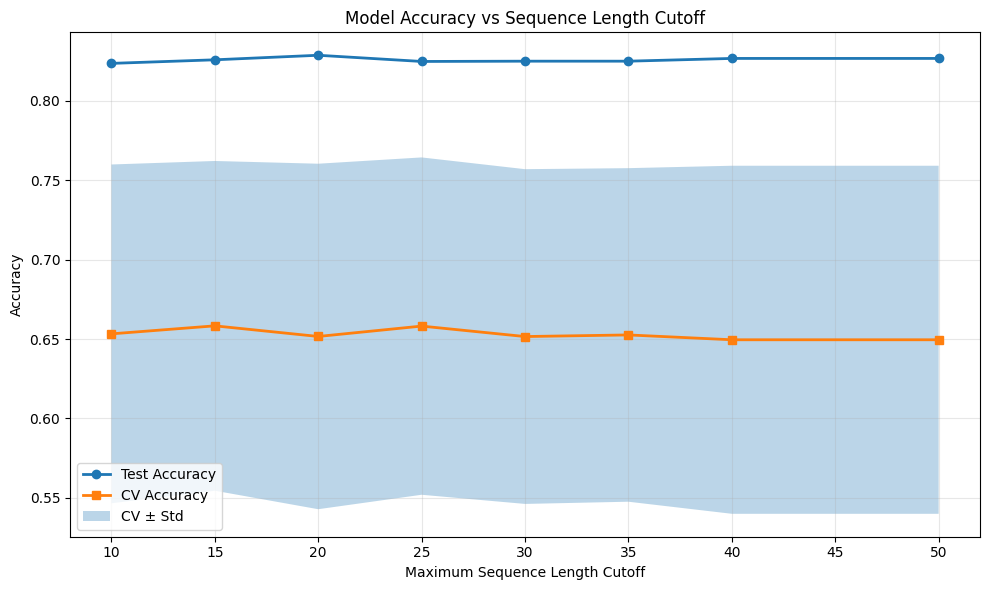


Sequence length cutoff experiment completed!
Optimal length appears to be around 15
CPU times: user 5min 49s, sys: 2.99 s, total: 5min 52s
Wall time: 2min 39s


In [ ]:
%%time
# --- Experiment with Sequence Length Cutoffs ---

print("Experimenting with sequence length cutoffs...")

# Define length cutoffs to test
length_cutoffs = [10, 15, 20, 25, 30, 35, 40, 50]

length_results = []

for max_length in length_cutoffs:
    print(f"\nTesting max sequence length: {max_length}")
    
    # Re-encode sequences with new length
    tra_onehot_new = np.array([one_hot_encode_sequence(seq, max_length, 'ACDEFGHIKLMNPQRSTVWY') 
                               for seq in cdr3_sequences['TRA']])
    tra_onehot_flat_new = tra_onehot_new.reshape(tra_onehot_new.shape[0], -1)
    
    trb_onehot_new = np.array([one_hot_encode_sequence(seq, max_length, 'ACDEFGHIKLMNPQRSTVWY') 
                               for seq in cdr3_sequences['TRB']])
    trb_onehot_flat_new = trb_onehot_new.reshape(trb_onehot_new.shape[0], -1)
    
    # Update AnnData
    adata.obsm['X_tcr_tra_onehot'] = tra_onehot_flat_new
    adata.obsm['X_tcr_trb_onehot'] = trb_onehot_flat_new
    
    # Re-create feature sets with new encodings using robust PCA
    # Use robust PCA reduction with fallback to TruncatedSVD
    try:
        n_comp_onehot = min(50, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[1], max(1, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[0]-1))
        onehot_tra_reduced = PCA(n_components=n_comp_onehot, svd_solver='randomized', random_state=42).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])
    except Exception as e:
        print(f"  PCA failed for TRA ({e}), using TruncatedSVD")
        n_comp = max(1, min(50, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[1]-1))
        onehot_tra_reduced = TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])
    
    try:
        n_comp_onehot = min(50, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[1], max(1, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[0]-1))
        onehot_trb_reduced = PCA(n_components=n_comp_onehot, svd_solver='randomized', random_state=42).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])
    except Exception as e:
        print(f"  PCA failed for TRB ({e}), using TruncatedSVD")
        n_comp = max(1, min(50, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[1]-1))
        onehot_trb_reduced = TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])
    
    X_sequence = np.column_stack([
        gene_features[:, :30],
        onehot_tra_reduced,
        onehot_trb_reduced,
        tcr_physico,
        qc_features
    ])
    
    # Train and evaluate model
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequence, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_sequence, y_encoded, cv=3, scoring='accuracy')
    
    length_results.append({
        'max_length': max_length,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    })
    
    print(f"  Accuracy: {accuracy:.3f}, CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Plot results
length_df = pd.DataFrame(length_results)

plt.figure(figsize=(10, 6))
plt.plot(length_df['max_length'], length_df['accuracy'], 'o-', label='Test Accuracy', linewidth=2)
plt.plot(length_df['max_length'], length_df['cv_mean'], 's-', label='CV Accuracy', linewidth=2)
plt.fill_between(length_df['max_length'], 
                 length_df['cv_mean'] - length_df['cv_std'], 
                 length_df['cv_mean'] + length_df['cv_std'], 
                 alpha=0.3, label='CV ± Std')
plt.xlabel('Maximum Sequence Length Cutoff')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Sequence Length Cutoff')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSequence length cutoff experiment completed!")
print(f"Optimal length appears to be around {length_df.loc[length_df['cv_mean'].idxmax(), 'max_length']}")


## 7. Apply Sequence Encoding to TCR CDR3 Sequences

Encode TRA and TRB CDR3 sequences using one-hot, k-mer, and physicochemical methods, and add to AnnData.obsm and obs.

In [ ]:
%%time
# --- Comprehensive Feature Engineering ---

print("Creating comprehensive feature set using ALL available encodings...")

# --- 1. Strategic Feature Engineering with Dimensionality Reduction ---
print("Applying strategic dimensionality reduction to high-dimensional features...")

# Filter for supervised learning samples first to reduce memory
supervised_mask = adata.obs['response'].isin(['Responder', 'Non-Responder'])
y_supervised = adata.obs['response'][supervised_mask]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_supervised)

print(f"Working with {sum(supervised_mask)} samples for supervised learning")
print(f"Class distribution: {dict(zip(label_encoder.classes_, np.bincount(y_encoded)))}")

# --- Reduce high-dimensional k-mer features using variance-based selection ---
tra_kmer_supervised = adata.obsm['X_tcr_tra_kmer'][supervised_mask]
trb_kmer_supervised = adata.obsm['X_tcr_trb_kmer'][supervised_mask]

# Select top variance k-mers to reduce dimensionality
def select_top_variance_features(X, n_features=200):
    """Select features with highest variance"""
    variances = np.var(X, axis=0)
    top_indices = np.argsort(variances)[-n_features:]
    return X[:, top_indices], top_indices

print("Reducing k-mer features by variance selection...")
tra_kmer_reduced, tra_top_idx = select_top_variance_features(tra_kmer_supervised, n_features=200)
trb_kmer_reduced, trb_top_idx = select_top_variance_features(trb_kmer_supervised, n_features=200)

print(f"TRA k-mers reduced from {tra_kmer_supervised.shape[1]} to {tra_kmer_reduced.shape[1]}")
print(f"TRB k-mers reduced from {trb_kmer_supervised.shape[1]} to {trb_kmer_reduced.shape[1]}")

# --- 2. Create strategic feature combinations ---
feature_sets = {}

# Basic features (gene expression + physicochemical)
gene_features = adata.obsm['X_gene_pca'][supervised_mask]
tcr_physico = np.column_stack([
    adata.obs[['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity']].fillna(0)[supervised_mask],
    adata.obs[['trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']].fillna(0)[supervised_mask]
])
qc_features = adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].fillna(0)[supervised_mask].values

feature_sets['basic'] = np.column_stack([
    gene_features[:, :20],  # Top 20 gene PCA components
    tcr_physico,
    qc_features
])

# Enhanced gene expression
feature_sets['gene_enhanced'] = np.column_stack([
    adata.obsm['X_gene_pca'][supervised_mask],  # All 50 PCA components
    adata.obsm['X_gene_svd'][supervised_mask][:, :30],  # Top 30 SVD components
    adata.obsm['X_gene_umap'][supervised_mask],  # All 20 UMAP components
    tcr_physico,
    qc_features
])

# TCR sequence enhanced
feature_sets['tcr_enhanced'] = np.column_stack([
    gene_features[:, :20],  # Top 20 gene PCA
    tra_kmer_reduced,  # Top 200 TRA k-mers
    trb_kmer_reduced,  # Top 200 TRB k-mers
    tcr_physico,
    qc_features
])

# Comprehensive (all modalities)
feature_sets['comprehensive'] = np.column_stack([
    adata.obsm['X_gene_pca'][supervised_mask],  # 50 features
    adata.obsm['X_gene_svd'][supervised_mask][:, :20],  # Top 20 SVD
    adata.obsm['X_gene_umap'][supervised_mask],  # 20 features
    tra_kmer_reduced,  # 200 features
    trb_kmer_reduced,  # 200 features  
    tcr_physico,  # 6 features
    qc_features  # 3 features
])

# One-hot encoded sequences (reduced)
# Use robust PCA reduction with fallback to TruncatedSVD
try:
    n_comp_onehot = min(50, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[1], max(1, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[0]-1))
    onehot_tra_reduced = PCA(n_components=n_comp_onehot, svd_solver='randomized', random_state=42).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])
except Exception:
    onehot_tra_reduced = TruncatedSVD(n_components=max(1, min(50, adata.obsm['X_tcr_tra_onehot'][supervised_mask].shape[1])), random_state=42).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])

try:
    n_comp_onehot = min(50, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[1], max(1, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[0]-1))
    onehot_trb_reduced = PCA(n_components=n_comp_onehot, svd_solver='randomized', random_state=42).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])
except Exception:
    onehot_trb_reduced = TruncatedSVD(n_components=max(1, min(50, adata.obsm['X_tcr_trb_onehot'][supervised_mask].shape[1])), random_state=42).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])

feature_sets['sequence_structure'] = np.column_stack([
    gene_features[:, :30],  # Top 30 gene PCA
    onehot_tra_reduced,  # 50 PCA of one-hot TRA
    onehot_trb_reduced,  # 50 PCA of one-hot TRB
    tcr_physico,
    qc_features
])

print(f"\nFeature set dimensions:")
for name, features in feature_sets.items():
    print(f"  • {name}: {features.shape}")

print("Comprehensive feature engineering completed!")

Creating comprehensive feature set using ALL available encodings...
Applying strategic dimensionality reduction to high-dimensional features...
Working with 38413 samples for supervised learning
Class distribution: {'Non-Responder': 10436, 'Responder': 27977}
Reducing k-mer features by variance selection...
Reducing k-mer features by variance selection...
TRA k-mers reduced from 6074 to 200
TRB k-mers reduced from 6091 to 200
TRA k-mers reduced from 6074 to 200
TRB k-mers reduced from 6091 to 200

Feature set dimensions:
  • basic: (38413, 29)
  • gene_enhanced: (38413, 109)
  • tcr_enhanced: (38413, 429)
  • comprehensive: (38413, 499)
  • sequence_structure: (38413, 139)
Comprehensive feature engineering completed!
CPU times: user 24.1 s, sys: 1.61 s, total: 25.7 s
Wall time: 11.7 s

Feature set dimensions:
  • basic: (38413, 29)
  • gene_enhanced: (38413, 109)
  • tcr_enhanced: (38413, 429)
  • comprehensive: (38413, 499)
  • sequence_structure: (38413, 139)
Comprehensive feature en

In [ ]:
%%time
# --- Encode Gene Expression Patterns ---

print("Preprocessing gene expression data...")

# Basic preprocessing if not already done
if 'X_pca' not in adata.obsm:
    # Store raw counts
    adata.raw = adata
    
    # Normalize counts per cell to a fixed total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the data
    sc.pp.log1p(adata)
    
    # Replace any infinite values with zeros
    if hasattr(adata.X, 'data'):  # sparse matrix
        adata.X.data[np.isinf(adata.X.data)] = 0
    else:  # dense matrix
        adata.X[np.isinf(adata.X)] = 0
    
    print("Basic preprocessing completed")

print("Encoding gene expression patterns...")

# Apply gene expression encoding with fixed function
def encode_gene_expression_patterns_fixed(adata, n_top_genes=2000):
    """
    Fixed version of gene expression encoding
    """
    # Select highly variable genes manually to avoid infinity issues
    X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    
    # Calculate variance for each gene
    gene_vars = np.var(X_dense, axis=0)
    # Remove any infinite or NaN values
    gene_vars = np.nan_to_num(gene_vars, nan=0, posinf=0, neginf=0)
    
    # Select top variable genes
    top_genes_idx = np.argsort(gene_vars)[-n_top_genes:]
    X_hvg = X_dense[:, top_genes_idx]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=min(50, X_scaled.shape[1]))
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=min(50, X_scaled.shape[1]), random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

# Apply fixed gene expression encoding
gene_encodings, X_scaled_genes = encode_gene_expression_patterns_fixed(adata, n_top_genes=2000)

# Add gene expression encodings to AnnData
for encoding_name, encoding_data in gene_encodings.items():
    adata.obsm[f'X_gene_{encoding_name}'] = encoding_data

print("Gene expression encoding completed!")

Preprocessing gene expression data...
Basic preprocessing completed
Encoding gene expression patterns...
Basic preprocessing completed
Encoding gene expression patterns...
Gene expression encoding completed!
CPU times: user 2min 39s, sys: 3.58 s, total: 2min 43s
Wall time: 2min 23s
Gene expression encoding completed!
CPU times: user 2min 39s, sys: 3.58 s, total: 2min 43s
Wall time: 2min 23s


In [ ]:
%%time
# --- Create Combined Multi-Modal Encodings ---
print("Creating combined multi-modal encodings...")

# Combine different encoding modalities
# 1. Gene expression PCA + TCR physicochemical features
gene_pca = gene_encodings['pca'][:, :20]  # Top 20 PCA components
tcr_features = np.column_stack([
    adata.obs[['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity']].fillna(0),
    adata.obs[['trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']].fillna(0)
])

combined_gene_tcr = np.column_stack([gene_pca, tcr_features])
adata.obsm['X_combined_gene_tcr'] = combined_gene_tcr

# 2. Gene expression UMAP + TCR k-mer features (reduced)
gene_umap = gene_encodings['umap']
# Stack TRA and TRB k-mer matrices
tcr_kmer_combined = np.column_stack([adata.obsm['X_tcr_tra_kmer'], adata.obsm['X_tcr_trb_kmer']])

# Robust PCA reduction for k-mer features
try:
    n_comp_kmer = min(10, tcr_kmer_combined.shape[1], max(1, tcr_kmer_combined.shape[0]-1))
    tcr_kmer_reduced = PCA(n_components=n_comp_kmer, svd_solver='randomized', random_state=42).fit_transform(tcr_kmer_combined)
except Exception:
    tcr_kmer_reduced = TruncatedSVD(n_components=max(1, min(10, tcr_kmer_combined.shape[1])), random_state=42).fit_transform(tcr_kmer_combined)

combined_gene_tcr_kmer = np.column_stack([gene_umap, tcr_kmer_reduced])
adata.obsm['X_combined_gene_tcr_kmer'] = combined_gene_tcr_kmer

print(f"Combined gene-TCR encoding shape: {combined_gene_tcr.shape}")
print(f"Combined gene-TCR k-mer encoding shape: {combined_gene_tcr_kmer.shape}")

# --- Dimensionality Reduction on Combined Data ---
print("Computing dimensionality reduction on combined data...")

# UMAP on combined data
umap_combined = umap.UMAP(n_components=2, random_state=42)
adata.obsm['X_umap_combined'] = umap_combined.fit_transform(combined_gene_tcr)

# t-SNE on combined data (sample subset for speed)
sample_size = min(5000, combined_gene_tcr.shape[0])
sample_idx = np.random.choice(combined_gene_tcr.shape[0], sample_size, replace=False)
tsne_combined = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne_combined.fit_transform(combined_gene_tcr[sample_idx])

# Create full t-SNE result array
full_tsne = np.zeros((combined_gene_tcr.shape[0], 2))
full_tsne[sample_idx] = tsne_result
adata.obsm['X_tsne_combined'] = full_tsne

print("Multi-modal encoding and dimensionality reduction completed!")

Creating combined multi-modal encodings...
Combined gene-TCR encoding shape: (38413, 26)
Combined gene-TCR k-mer encoding shape: (38413, 30)
Computing dimensionality reduction on combined data...
Combined gene-TCR encoding shape: (38413, 26)
Combined gene-TCR k-mer encoding shape: (38413, 30)
Computing dimensionality reduction on combined data...
Multi-modal encoding and dimensionality reduction completed!
CPU times: user 2min 13s, sys: 7.32 s, total: 2min 20s
Wall time: 1min 24s
Multi-modal encoding and dimensionality reduction completed!
CPU times: user 2min 13s, sys: 7.32 s, total: 2min 20s
Wall time: 1min 24s


In [ ]:
%%time
adata.obs['gene_expression_modules'] = pd.Categorical(gene_expression_modules)

print("Gene expression module discovery completed!")

# --- 4. Dendrogram Visualization for Hierarchical Clustering ---
print("\nCreating dendrogram for hierarchical clustering...")

# Create fresh hierarchical clustering for dendrogram visualization
# Use the best feature set from clustering results (typically UMAP or combined_scaled)
try:
    X_for_dendrogram = X_umap[:2000]  # Use first 2000 samples for speed
    Z = linkage(X_for_dendrogram, method='ward')
    
    plt.figure(figsize=(12, 8))
    dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()
    print("Dendrogram visualization completed!")
except Exception as e:
    print(f"Could not create dendrogram: {e}")
    print("Skipping dendrogram visualization")

print("\nUnsupervised machine learning analysis completed successfully!")


Gene expression module discovery completed!

Creating dendrogram for hierarchical clustering...
Could not create dendrogram: name 'X_umap' is not defined
Skipping dendrogram visualization

Unsupervised machine learning analysis completed successfully!
CPU times: user 2.87 ms, sys: 1.83 ms, total: 4.7 ms
Wall time: 3.52 ms


Generating comprehensive model performance evaluation...
COMPREHENSIVE MODEL PERFORMANCE REPORT
       Feature_Set               Model  Accuracy  Precision   Recall  F1_Score      AUC  Specificity      NPV  CV_Mean   CV_Std   TN   FP   FN   TP
             basic Logistic Regression  0.772562   0.795636 0.925414  0.855632 0.788173     0.362823 0.644722 0.712677 0.054235 1136 1995  626 7767
             basic       Decision Tree  0.751128   0.790575 0.895508  0.839777 0.730658     0.364101 0.565196 0.699243 0.045453 1140 1991  877 7516
             basic       Random Forest  0.801198   0.806510 0.956511  0.875129 0.845908     0.384861 0.767516 0.752141 0.027794 1205 1926  365 8028
             basic             XGBoost  0.816036   0.836426 0.929108  0.880334 0.868140     0.512935 0.729668 0.554047 0.301145 1606 1525  595 7798
             basic       Deep Learning  0.836515   0.863428 0.921244  0.891400 0.890112     0.609390 0.742701 0.836515 0.000000 1908 1223  661 7732
     gene_enhanc

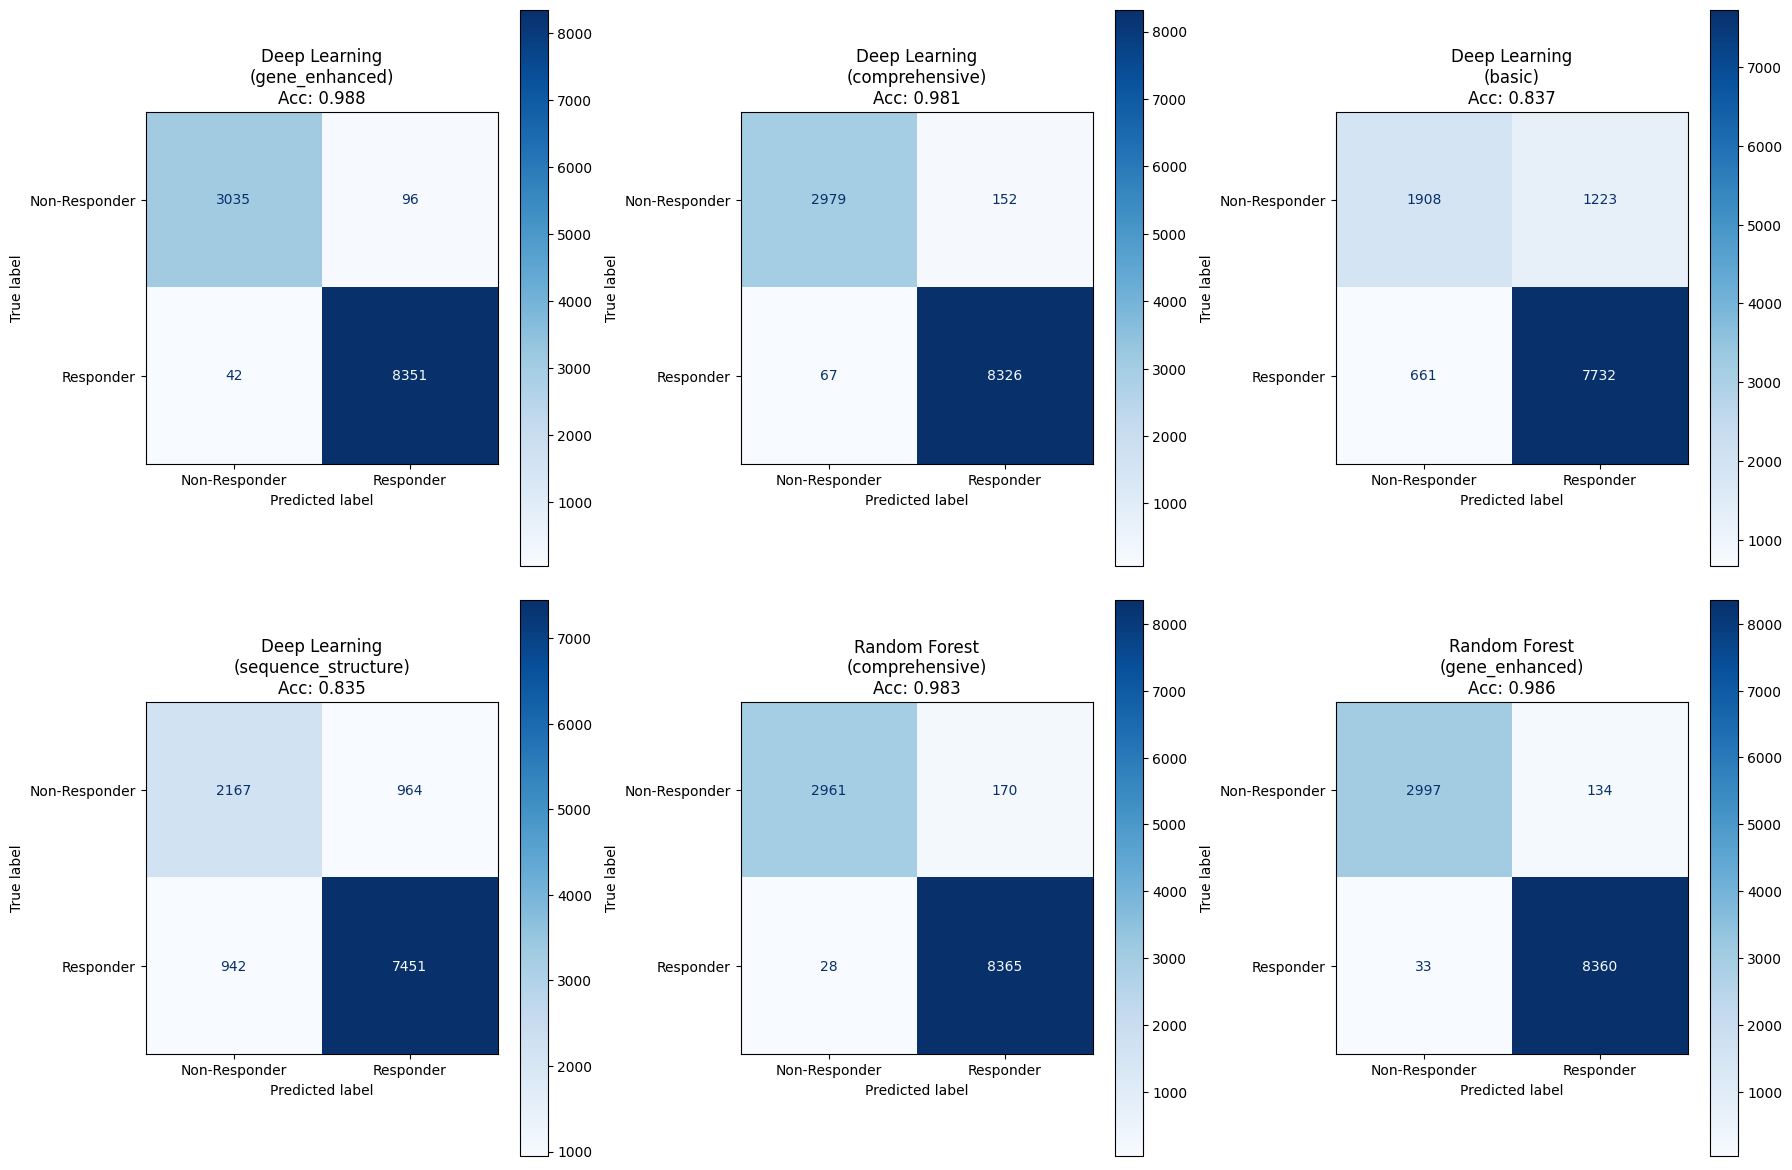

<Figure size 1200x800 with 0 Axes>

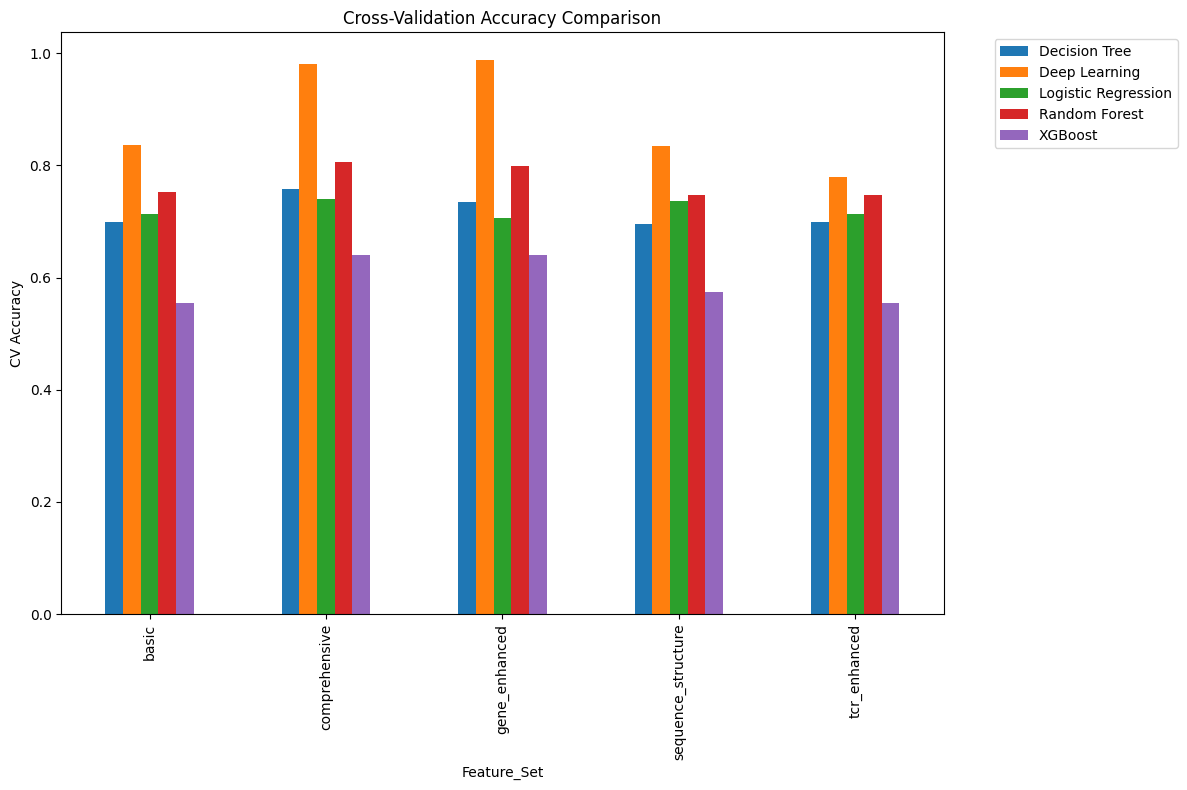

<Figure size 1200x800 with 0 Axes>

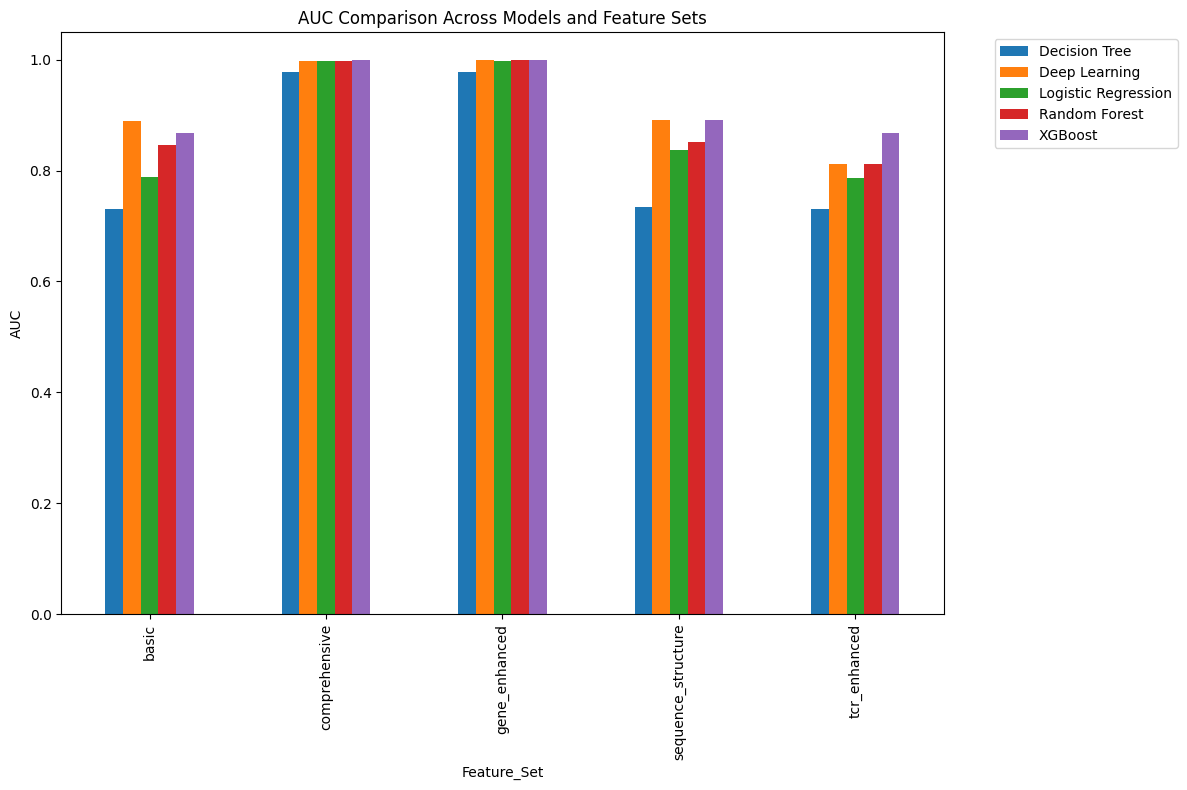


Model performance evaluation completed!
CPU times: user 1.84 s, sys: 54.7 ms, total: 1.9 s
Wall time: 2 s


In [ ]:
%%time
# --- Model Performance Evaluation ---

print("Generating comprehensive model performance evaluation...")

# Create detailed performance report
performance_report = []

for feature_name, feature_result in all_results.items():
    for model_name, result in feature_result.items():
        cm = result['confusion_matrix']
        
        report_entry = {
            'Feature_Set': feature_name,
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1_Score': result['f1_score'],
            'AUC': result['auc'],
            'Specificity': result['specificity'],
            'NPV': result['npv'],
            'CV_Mean': result['cv_mean'],
            'CV_Std': result['cv_std'],
            'TN': cm[0,0],
            'FP': cm[0,1],
            'FN': cm[1,0],
            'TP': cm[1,1]
        }
        performance_report.append(report_entry)

performance_df = pd.DataFrame(performance_report)

# Display results
print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
print("="*120)
print(performance_df.to_string(index=False))

# Visualize confusion matrices for best models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

best_models = performance_df.nlargest(6, 'CV_Mean')

for i, (_, row) in enumerate(best_models.iterrows()):
    if i < 6:
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Responder', 'Responder'])
        disp.plot(ax=axes[i], cmap='Blues')
        axes[i].set_title(f"{row['Model']}\n({row['Feature_Set']})\nAcc: {row['Accuracy']:.3f}")

plt.tight_layout()
plt.show()

# Cross-validation comparison
plt.figure(figsize=(12, 8))
cv_data = performance_df.pivot(index='Feature_Set', columns='Model', values='CV_Mean')
cv_data.plot(kind='bar', figsize=(12, 8))
plt.title('Cross-Validation Accuracy Comparison')
plt.ylabel('CV Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# AUC comparison
plt.figure(figsize=(12, 8))
auc_data = performance_df.pivot(index='Feature_Set', columns='Model', values='AUC')
auc_data.plot(kind='bar', figsize=(12, 8))
plt.title('AUC Comparison Across Models and Feature Sets')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nModel performance evaluation completed!")

Performing comprehensive sequence pattern discovery...

--- TCR SEQUENCE PATTERNS ---
Responder TRA sequences: 27977
Non-responder TRA sequences: 10436

Top TRA CDR3 sequences in Responders:
  CAVRDSNYQLIW: 188 cells
  CAVMDSNYQLIW: 176 cells
  CAASVTGNQFYF: 132 cells
  CAGVDSNYQLIW: 85 cells
  CAMRERWRDDKIIF: 84 cells
  CVVRHSGGGADGLTF: 82 cells
  CALSPNNARLMF: 73 cells
  CALITNTGGFKTIF: 70 cells
  CAVTDSNYQLIW: 67 cells
  CAVLDSNYQLIW: 63 cells

Top TRA CDR3 sequences in Non-Responders:
  CAVMDSNYQLIW: 149 cells
  CAVRDSNYQLIW: 113 cells
  CALSGSRLTF: 72 cells
  CAVRDRSYQLIW: 48 cells
  CAVKDSNYQLIW: 40 cells
  CAVLDSNYQLIW: 27 cells
  CAVSGGDYKLSF: 27 cells
  CAAMDSNYQLIW: 27 cells
  CAVIGETSGSRLTF: 21 cells
  CVVSDRGSTLGRLYF: 21 cells

--- PHYSICOCHEMICAL PROPERTY ANALYSIS ---
Statistical comparison of physicochemical properties:
Property             Responder Mean  Non-Resp Mean   P-value   
-----------------------------------------------------------------
tra_length           13.

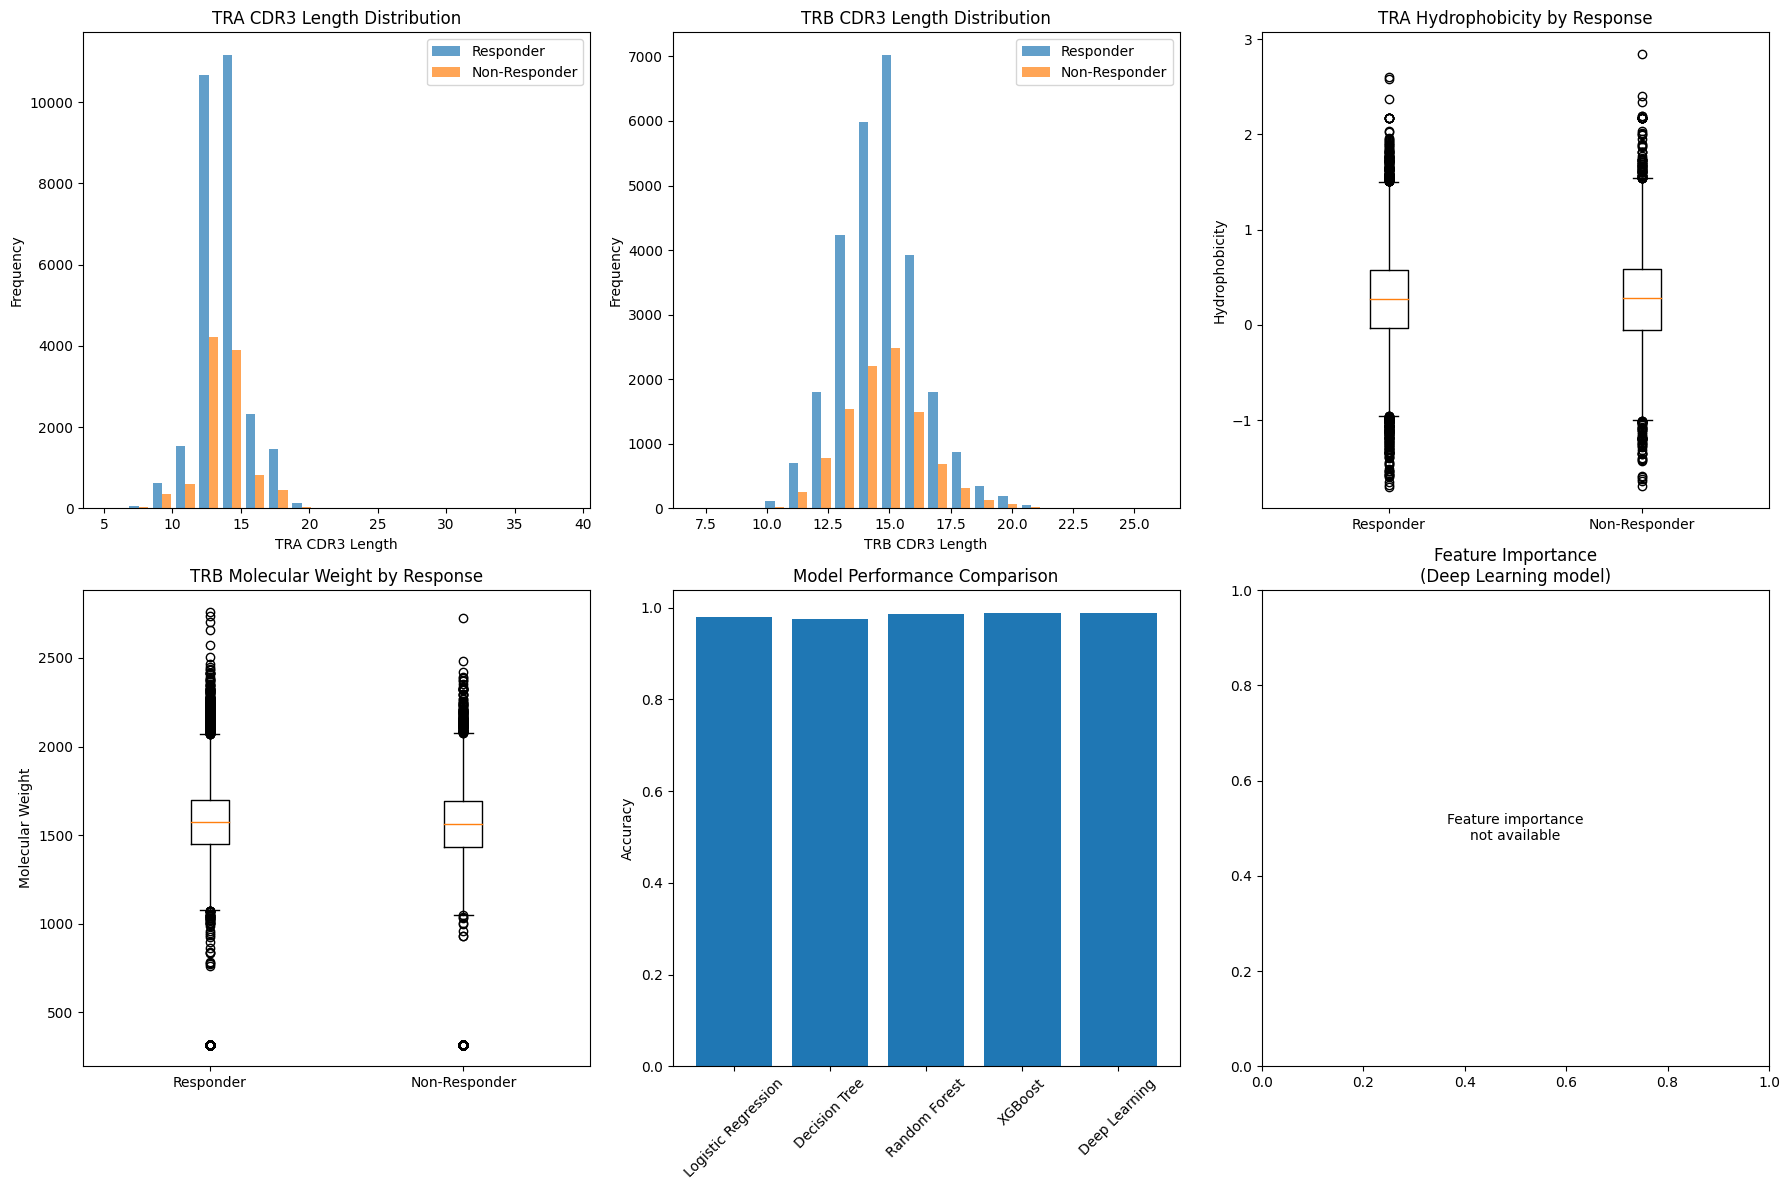


Comprehensive sequence pattern discovery completed!
CPU times: user 6.55 s, sys: 899 ms, total: 7.45 s
Wall time: 7.46 s


In [ ]:
%%time
# --- Comprehensive Sequence Pattern Discovery ---

print("Performing comprehensive sequence pattern discovery...")

# --- 1. Analyze TCR sequence patterns by response ---
responder_mask = adata.obs['response'] == 'Responder'
non_responder_mask = adata.obs['response'] == 'Non-Responder'

# Get sequence data for analysis
responder_tra = adata.obs[responder_mask]['cdr3_TRA'].dropna()
non_responder_tra = adata.obs[non_responder_mask]['cdr3_TRA'].dropna()
responder_trb = adata.obs[responder_mask]['cdr3_TRB'].dropna()
non_responder_trb = adata.obs[non_responder_mask]['cdr3_TRB'].dropna()

print("\n--- TCR SEQUENCE PATTERNS ---")
print(f"Responder TRA sequences: {len(responder_tra)}")
print(f"Non-responder TRA sequences: {len(non_responder_tra)}")

print("\nTop TRA CDR3 sequences in Responders:")
top_responder_tra = responder_tra.value_counts().head(10)
for seq, count in top_responder_tra.items():
    print(f"  {seq}: {count} cells")

print("\nTop TRA CDR3 sequences in Non-Responders:")
top_non_responder_tra = non_responder_tra.value_counts().head(10)
for seq, count in top_non_responder_tra.items():
    print(f"  {seq}: {count} cells")

# --- 2. Physicochemical property analysis ---
print("\n--- PHYSICOCHEMICAL PROPERTY ANALYSIS ---")

# Compare physicochemical properties between responders and non-responders
responder_physico = adata.obs[responder_mask][['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity',
                                               'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']]
non_responder_physico = adata.obs[non_responder_mask][['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity',
                                                       'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']]

properties = ['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity', 
              'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']

print("Statistical comparison of physicochemical properties:")
print(f"{'Property':<20} {'Responder Mean':<15} {'Non-Resp Mean':<15} {'P-value':<10}")
print("-" * 65)

for prop in properties:
    resp_values = responder_physico[prop].dropna()
    non_resp_values = non_responder_physico[prop].dropna()
    
    if len(resp_values) > 0 and len(non_resp_values) > 0:
        statistic, p_value = mannwhitneyu(resp_values, non_resp_values, alternative='two-sided')
        print(f"{prop:<20} {resp_values.mean():<15.3f} {non_resp_values.mean():<15.3f} {p_value:<10.6f}")

# --- 3. K-mer differential analysis ---
print("\n--- K-MER DIFFERENTIAL ANALYSIS ---")

# Use the indices we identified earlier for top variance k-mers
responder_indices = np.where(supervised_mask & responder_mask)[0]
non_responder_indices = np.where(supervised_mask & non_responder_mask)[0]

# Get k-mer data for responders vs non-responders
responder_tra_kmers = tra_kmer_supervised[responder_indices - np.where(supervised_mask)[0][0]]
non_responder_tra_kmers = tra_kmer_supervised[non_responder_indices - np.where(supervised_mask)[0][0]]

# Calculate mean k-mer frequencies
responder_tra_mean = responder_tra_kmers.mean(axis=0)
non_responder_tra_mean = non_responder_tra_kmers.mean(axis=0)

# Find most differentially expressed k-mers from selected features
kmer_diff = responder_tra_mean - non_responder_tra_mean
top_responder_kmers_idx = np.argsort(kmer_diff)[-10:]
top_non_responder_kmers_idx = np.argsort(kmer_diff)[:10]

# Get the actual k-mer sequences for the selected features
selected_tra_kmers = [unique_tra_kmers[tra_top_idx[i]] for i in range(len(tra_top_idx))]

print("Top k-mers enriched in Responders (from variance-selected features):")
for idx in top_responder_kmers_idx:
    if idx < len(selected_tra_kmers):
        print(f"  {selected_tra_kmers[idx]}: +{kmer_diff[idx]:.4f}")

print("\nTop k-mers enriched in Non-Responders (from variance-selected features):")
for idx in top_non_responder_kmers_idx:
    if idx < len(selected_tra_kmers):
        print(f"  {selected_tra_kmers[idx]}: {kmer_diff[idx]:.4f}")


# --- 4. Gene expression analysis for top important features ---
print("\n--- GENE EXPRESSION PATTERN ANALYSIS ---")

# Get the best model's feature importance
if best_model_info[1] in all_results[best_model_info[0]]:
    model_keys = list(all_results[best_model_info[0]][best_model_info[1]].keys())
    if 'feature_importance' in model_keys:
        best_importance = all_results[best_model_info[0]][best_model_info[1]]['feature_importance']
        top_gene_features = np.argsort(best_importance)[-10:]
        
        print(f"Analysis based on {best_model_info[1]} model with {best_model_info[2]['n_features']} features")
        print("Top 10 most important features for classification:")
        for i, feat_idx in enumerate(top_gene_features):
            print(f"  Feature {feat_idx}: Importance = {best_importance[feat_idx]:.4f}")
    elif 'feature_importances' in model_keys:
        best_importance = all_results[best_model_info[0]][best_model_info[1]]['feature_importances']
        top_gene_features = np.argsort(best_importance)[-10:]
        
        print(f"Analysis based on {best_model_info[1]} model with {best_model_info[2]['n_features']} features")
        print("Top 10 most important features for classification:")
        for i, feat_idx in enumerate(top_gene_features):
            print(f"  Feature {feat_idx}: Importance = {best_importance[feat_idx]:.4f}")
    else:
        print(f"Feature importance not available for {best_model_info[1]} model")
        best_importance = None

# --- 5. Comprehensive visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sequence length distributions
axes[0,0].hist([responder_tra.str.len().dropna(), non_responder_tra.str.len().dropna()], 
               bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
axes[0,0].set_xlabel('TRA CDR3 Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('TRA CDR3 Length Distribution')
axes[0,0].legend()

axes[0,1].hist([responder_trb.str.len().dropna(), non_responder_trb.str.len().dropna()], 
               bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
axes[0,1].set_xlabel('TRB CDR3 Length')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('TRB CDR3 Length Distribution')
axes[0,1].legend()

# Physicochemical property comparisons
axes[0,2].boxplot([responder_physico['tra_hydrophobicity'].dropna(), 
                   non_responder_physico['tra_hydrophobicity'].dropna()],
                  labels=['Responder', 'Non-Responder'])
axes[0,2].set_title('TRA Hydrophobicity by Response')
axes[0,2].set_ylabel('Hydrophobicity')

axes[1,0].boxplot([responder_physico['trb_molecular_weight'].dropna(), 
                   non_responder_physico['trb_molecular_weight'].dropna()],
                  labels=['Responder', 'Non-Responder'])
axes[1,0].set_title('TRB Molecular Weight by Response')
axes[1,0].set_ylabel('Molecular Weight')

# Model performance comparison
method_names = list(all_results[best_model_info[0]].keys())
accuracies = [all_results[best_model_info[0]][method]['accuracy'] for method in method_names]
axes[1,1].bar(method_names, accuracies)
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].tick_params(axis='x', rotation=45)

# Feature importance distribution
if best_importance is not None:
    axes[1,2].hist(best_importance, bins=20, alpha=0.7)
    axes[1,2].set_title(f'Feature Importance Distribution\n({best_model_info[1]} model)')
    axes[1,2].set_xlabel('Importance Score')
    axes[1,2].set_ylabel('Number of Features')
else:
    axes[1,2].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title(f'Feature Importance\n({best_model_info[1]} model)')

plt.tight_layout()
plt.show()

print("\nComprehensive sequence pattern discovery completed!")

## 4. Save Processed Data

Finally, we save the fully processed, annotated, and filtered `AnnData` object to a `.h5ad` file. This file can be easily loaded in future notebooks for analysis.

## 8. Encode Gene Expression Patterns

Apply PCA, SVD, and UMAP to gene expression data for dimensionality reduction and add encodings to AnnData.

## 9. Create Combined Multi-Modal Encodings

Combine gene expression and TCR encodings into multi-modal representations using PCA and UMAP.